In [2]:
import numpy
import pandas
import bisect
import tensorflow
import pickle
import copy
import matplotlib.pyplot
import seaborn
import keras

In [3]:
def get_segment_info(labels):
    segment_info = []

    # Segment info
    curr_label = -1
    begin = -1

    for i in range(len(labels)):
        if curr_label != labels[i]:
            segment_info.append((curr_label, begin, i - 1))

            begin = i
            curr_label = labels[i]

    return segment_info

In [4]:
EPSILON = 1e-6

In [5]:
def is_within_range(mean_val, curr_val, max_relative_deviation):
    if abs(mean_val - curr_val) / max(EPSILON, abs(mean_val)) < max_relative_deviation:
        return True

    return False

In [6]:
def get_amp_freq(signal_segment, sampling_freq, freq_range):
    # Apply Hamming window to the signal segment
    window = numpy.hamming(len(signal_segment))
    corrected_signal_segment = signal_segment * window

    # Calculating amps and freqs
    fft_coefficients = numpy.fft.fft(signal_segment)
    amps = 2 / len(signal_segment) * numpy.abs(fft_coefficients)
    freqs = numpy.fft.fftfreq(len(amps), 1 / sampling_freq)

    # Taking the left half of amps and freqs
    amps = amps[0:len(amps) // 2]
    freqs = freqs[0:len(freqs) // 2]

    # Sorting amps and freqs by freqs
    sort_freqs = numpy.argsort(freqs)
    amps = amps[sort_freqs]
    freqs = freqs[sort_freqs]

    # Filter section within given freq_range
    left_index = bisect.bisect_right(freqs, freq_range[0])
    right_index = bisect.bisect_left(freqs, freq_range[1])
    amps = amps[left_index: right_index]
    freqs = freqs[left_index: right_index]

    # Sorting amps and freqs by amps
    sort_amps = numpy.argsort(amps)
    amps = amps[sort_amps][::-1]
    freqs = freqs[sort_amps][::-1]

    return amps, freqs

In [7]:
def get_segment_feature(signal_segment, sampling_freq, freq_range, max_relative_deviation, num_features):
    amps, freqs = get_amp_freq(signal_segment, sampling_freq, freq_range)

    amp_sum = amps[0]
    freq_sum = freqs[0]
    
    amp_to_consider = amps[0]
    freq_to_consider = freqs[0]
    
    n = 1
    features = []

    for i in range(len(amps)):
        if num_features == 0:
            break

        amp = amps[i]
        freq = freqs[i]

        is_ok = is_within_range(freq_sum / n, freq, max_relative_deviation)
        is_ok &= is_within_range(amp_sum / n, amp, max_relative_deviation)

        if is_ok:
            amp_sum += amp
            freq_sum += freq
            
            n += 1
        else:
            features.append((amp_to_consider, freq_to_consider))
            num_features -= 1

            amp_sum = amp
            freq_sum = freq
            n = 1
            
            amp_to_consider = amp
            freq_to_consider = freq

    return features

In [8]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

In [9]:
def get_signal_features(signal, segment_info, sampling_freq, window_len, overlap, freq_range, max_relative_deviation, num_features) :
    sub_segment_len = window_len * sampling_freq

    signal_features = []
    labels = []
    
    baseline_average = 0
    
    for curr_segment_info in segment_info :
        label = curr_segment_info[0]
        begin = curr_segment_info[1]
        end = curr_segment_info[2]
        
        if label >= IGNORE or label == TRANSIENT:
            continue
        
        segment = signal[begin:end]      
            
        if label == BASELINE :
            baseline_average = numpy.mean(segment)
        
        segment -= baseline_average
        
        curr_segment_len = end - begin        
        while curr_segment_len >= sub_segment_len:
            sub_segment = segment[int(curr_segment_len - sub_segment_len) : curr_segment_len]
            curr_segment_len -= int((1 - overlap) * sub_segment_len)
            
            segment_features = get_segment_feature(sub_segment, sampling_freq, freq_range, max_relative_deviation, num_features)            
            
            signal_features.append(segment_features)
            labels.append(label)
            
    return signal_features, labels

In [10]:
CHEST_SAMPLING_FREQ = 700
OVERLAP = 0.75
MAX_RELATIVE_DEVIATION = 0.2
NUM_FEATURES = 10

FREQ_RANGE = {
    "ECG" : (0.1, 150),
    "EMG" : (0, 1000),
    "EDA" : (0, 4),
    "Resp" : (0, 2),
}

WINDOW_LEN = {
    "ECG" : 30,
    "EMG" : 30,
    "EDA" : 30,
    "Resp" : 60,
}

ALIGN_LEN = 30

In [11]:
def align_list(feature_set, window_len, align_len) :
    tmp = 0
    i = 0
    
    new_set = []
    while i < len(feature_set) :
        new_set.append(feature_set[i])
        tmp += align_len
        i = int(tmp/window_len)
        
    return new_set

In [12]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['Resp', 'ECG', 'EMG', 'EDA', 'Temp', 'ACC']

In [13]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pandas.read_pickle(path)
    
    return subject

In [14]:
def get_flattened_feature_set(feature_set, size) :
    remove_index_set = []
    
    for i in range(size) :
        tmp_label = None
        index = None
        
        for signal_type in feature_set:
            if tmp_label is None :
                tmp_label = feature_set[signal_type]['labels'][i]
            elif feature_set[signal_type]['labels'][i] != tmp_label :
                index = i
                
        if index is not None :
            remove_index_set.append(index)
                
    remove_index_set = remove_index_set[::-1]
                
    for index in remove_index_set :
        for signal_type in feature_set :
            feature_set[signal_type]['labels'].pop(index)
            feature_set[signal_type]['signal_features'].pop(index)
            
    common_labels = None
    flattened_feature_set = {}
    
    for signal_type in feature_set :
        if common_labels is None :
            common_labels = feature_set[signal_type]['labels']
            
        flattened_feature_set[signal_type] = feature_set[signal_type]['signal_features']
    
    flattened_feature_set['labels'] = common_labels
    
    return flattened_feature_set

In [15]:
def one_hot_encode(labels) :
    new_labels = []
    
    for label in labels :
        new_label = []
        
        for i in range(4) :
            if i == label - 1 :
                new_label.append(1)
            else :
                new_label.append(0)
                
        new_labels.append(new_label)
        
    return new_labels

In [16]:
def one_hot_decode(labels) :
    new_labels = []
    
    for label in labels :
        for i in range(len(label)) :
            if label[i] == 1 :
                new_labels.append(i+1)

    return new_labels

In [17]:
def get_subject_feature(subject) :
    subject_data = read_subject_data(subject)
    segment_info = get_segment_info(subject_data['label'])
    
    feature_set = {}
    min_len = len(subject_data['label'])
    for signal_type in CHEST_SIGNALS :
        
        if signal_type == 'Temp' or signal_type == 'ACC' :
            continue
            
        signal = numpy.array(subject_data['signal']['chest'][signal_type]).flatten()

        freq_range = FREQ_RANGE[signal_type]
        window_len = WINDOW_LEN[signal_type]
        
        signal_features, labels = get_signal_features(signal, segment_info, CHEST_SAMPLING_FREQ, window_len, OVERLAP, freq_range, MAX_RELATIVE_DEVIATION, NUM_FEATURES)
        
        aligned_signal_features = align_list(signal_features, window_len, ALIGN_LEN)
        aligned_labels = align_list(labels, window_len, ALIGN_LEN)
        
        feature_set[signal_type] =  {
            'signal_features' : aligned_signal_features,
            'labels' : aligned_labels
        }
        
        min_len = min(min_len, len(aligned_signal_features))
        
    for signal_type in feature_set :
        feature_set[signal_type]['signal_features'] = feature_set[signal_type]['signal_features'][:min_len]
        feature_set[signal_type]['labels'] = feature_set[signal_type]['labels'][:min_len]
        
    flattened_feature_set = get_flattened_feature_set(feature_set, min_len)
    print("Completed :: Subject ", subject)
    
    return flattened_feature_set

In [18]:
def generate_dataset() :
    dataset = {}
    
    for subject in SUBJECTS :
        subject_signal_feature = get_subject_feature(subject)
        subject_signal_feature['labels'] = one_hot_encode(subject_signal_feature['labels'])
        dataset[subject] = subject_signal_feature
            
    return dataset

In [19]:
def generate_combined_dataset(dataset, subjects) :
    combined_dataset = {}
    
    for subject in subjects :
        for category in dataset[subject] :
            if category not in combined_dataset :
                combined_dataset[category] = []
            
            combined_dataset[category] += dataset[subject][category]
            
    return copy.deepcopy(combined_dataset)

In [20]:
def generate_lou_train_test_dataset(dataset, train_subjects, test_subjects) :
    train_dataset = generate_combined_dataset(dataset, train_subjects)
    test_dataset = generate_combined_dataset(dataset, test_subjects)
    
    return train_dataset, test_dataset

In [21]:
dataset = generate_dataset()
print(dataset)

Completed :: Subject  2
Completed :: Subject  3
Completed :: Subject  4
Completed :: Subject  5
Completed :: Subject  6
Completed :: Subject  7
Completed :: Subject  8
Completed :: Subject  9
Completed :: Subject  10
Completed :: Subject  11
Completed :: Subject  13
Completed :: Subject  14
Completed :: Subject  15
Completed :: Subject  16
Completed :: Subject  17


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
def save_dataset(dataset) :
    with open("../ExtraData/Dataset.pkl", "wb") as file :
        pickle.dump(dataset)

In [23]:
def load_dataset(dataset) :
    dataset = pandas.read_pickle("../ExtraData/Dataset.pkl")
    return dataset

In [24]:
def create_dataframe(dataset, feature_index_range) :
    combined_dataset = generate_combined_dataset(dataset, SUBJECTS)
    combined_dataset['labels'] = one_hot_decode(combined_dataset['labels'])
    
    visualization_dataset = {}
    
    for category in combined_dataset :
        if category == 'labels' :
            continue
            
        visualization_dataset[category] = []
        
        for points in combined_dataset[category] :
            visualization_dataset[category] += points[feature_index_range[0] : feature_index_range[1]]
            
        
    n = feature_index_range[1] - feature_index_range[0]
    visualization_dataset['labels'] = [str(label) for i in range(n) for label in combined_dataset['labels']]
    
    modified_visualization_dataset = {}
    signal_types = []
    
    for category in visualization_dataset :
        if category == 'labels' :
            modified_visualization_dataset['labels'] = visualization_dataset['labels']
            continue
         
        signal_types.append(category)
        modified_visualization_dataset[category + '_amp'] = [feature[0] for feature in visualization_dataset[category]]
        modified_visualization_dataset[category + '_freq'] = [feature[1] for feature in visualization_dataset[category]]
     
    return pandas.DataFrame.from_dict(modified_visualization_dataset), signal_types

In [25]:
def visualize_dataset(dataset) :    
    for i in range(NUM_FEATURES) :
        visualization_df, signal_types = create_dataframe(dataset, (i, i+1))
        for signal_type in signal_types :
            title = signal_type + "_" + str(i+1) + "th feature"
            matplotlib.pyplot.figure(figsize = (20, 15))
            seaborn.scatterplot(data=visualization_df, x=signal_type+"_freq", y=signal_type+"_amp", hue='labels', s=25, alpha=0.8).set(title=title)
            matplotlib.pyplot.savefig("../Visualizations/" + title + ".png", facecolor='white', format='png')
            

/tmp/ipykernel_82453/2889456681.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  matplotlib.pyplot.figure(figsize = (20, 15))


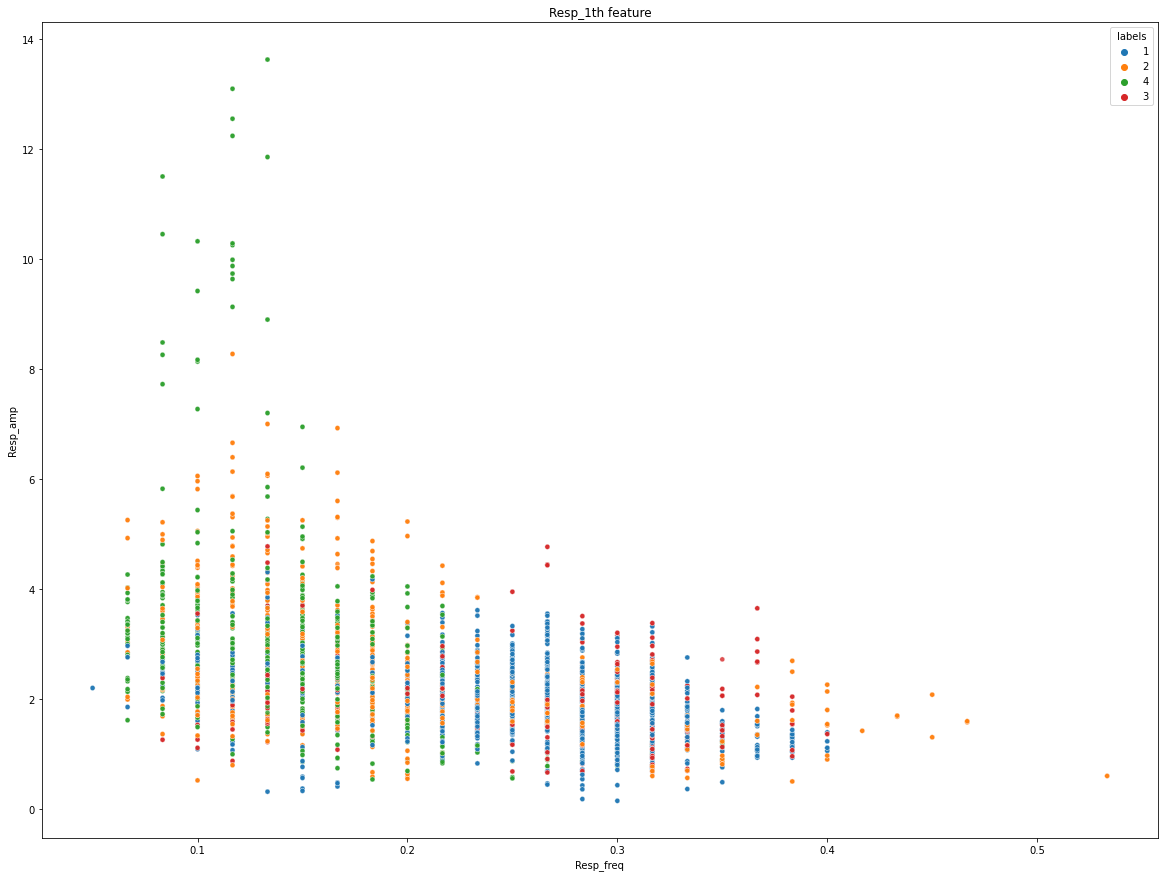

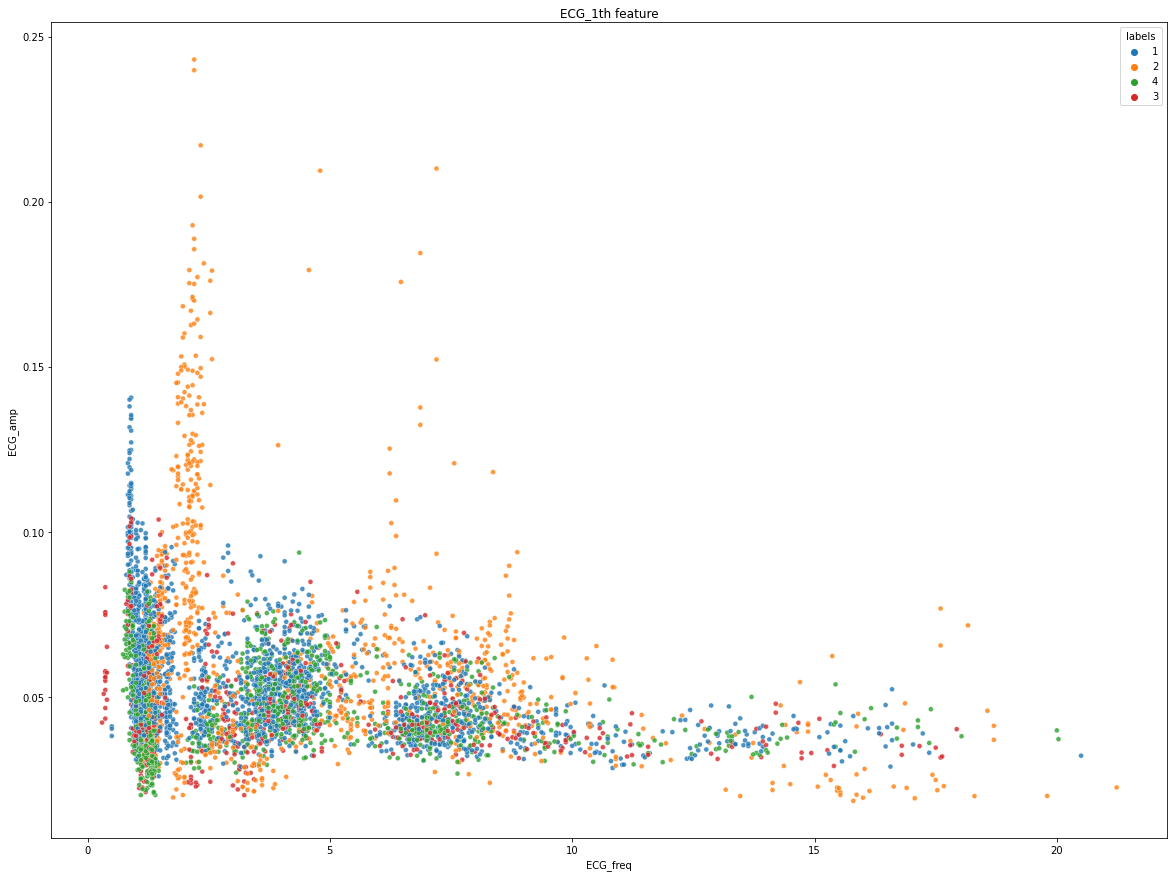

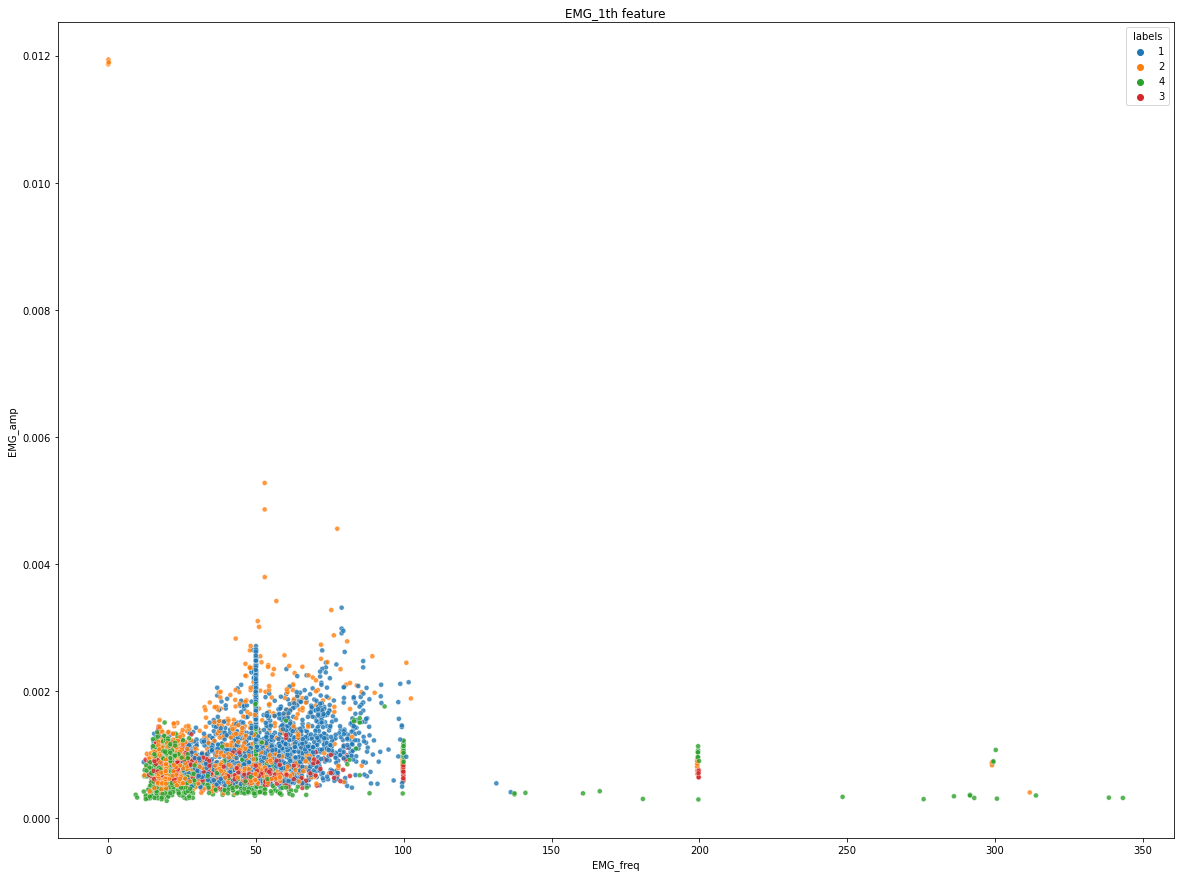

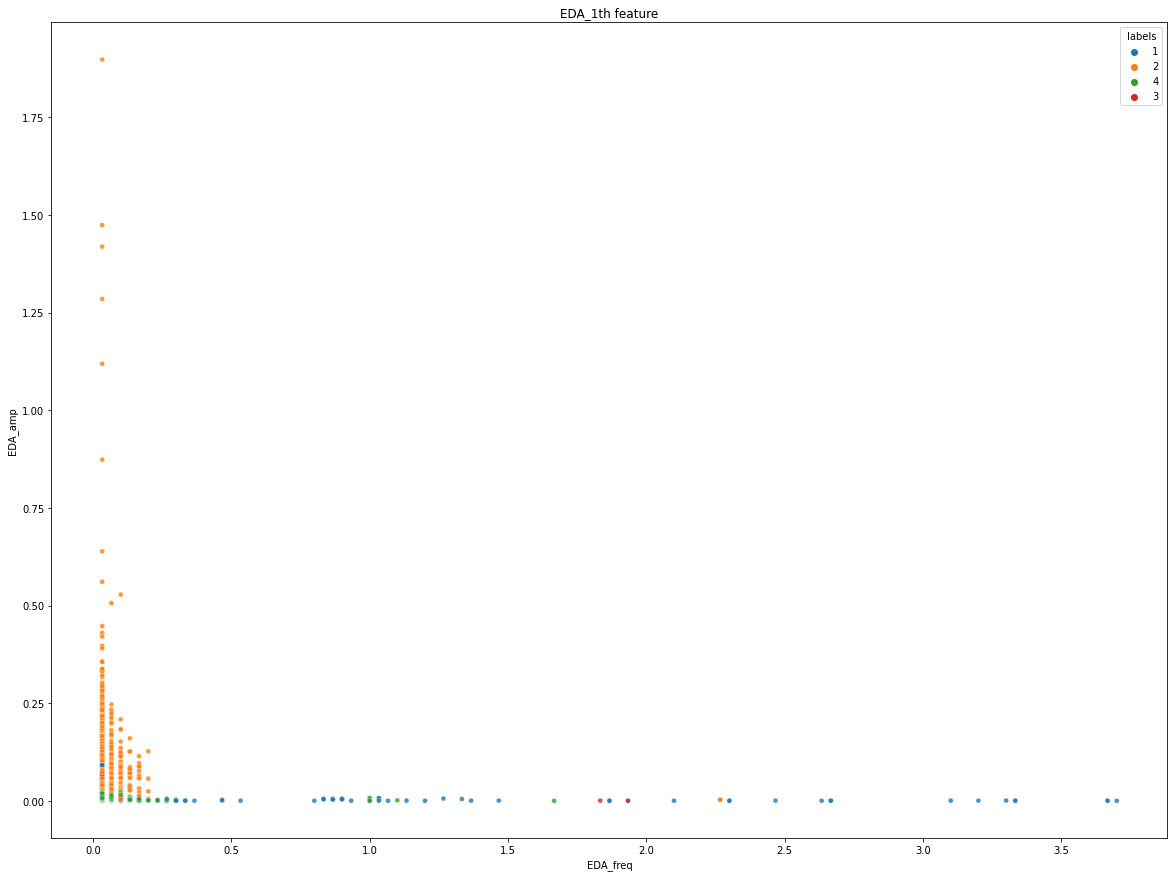

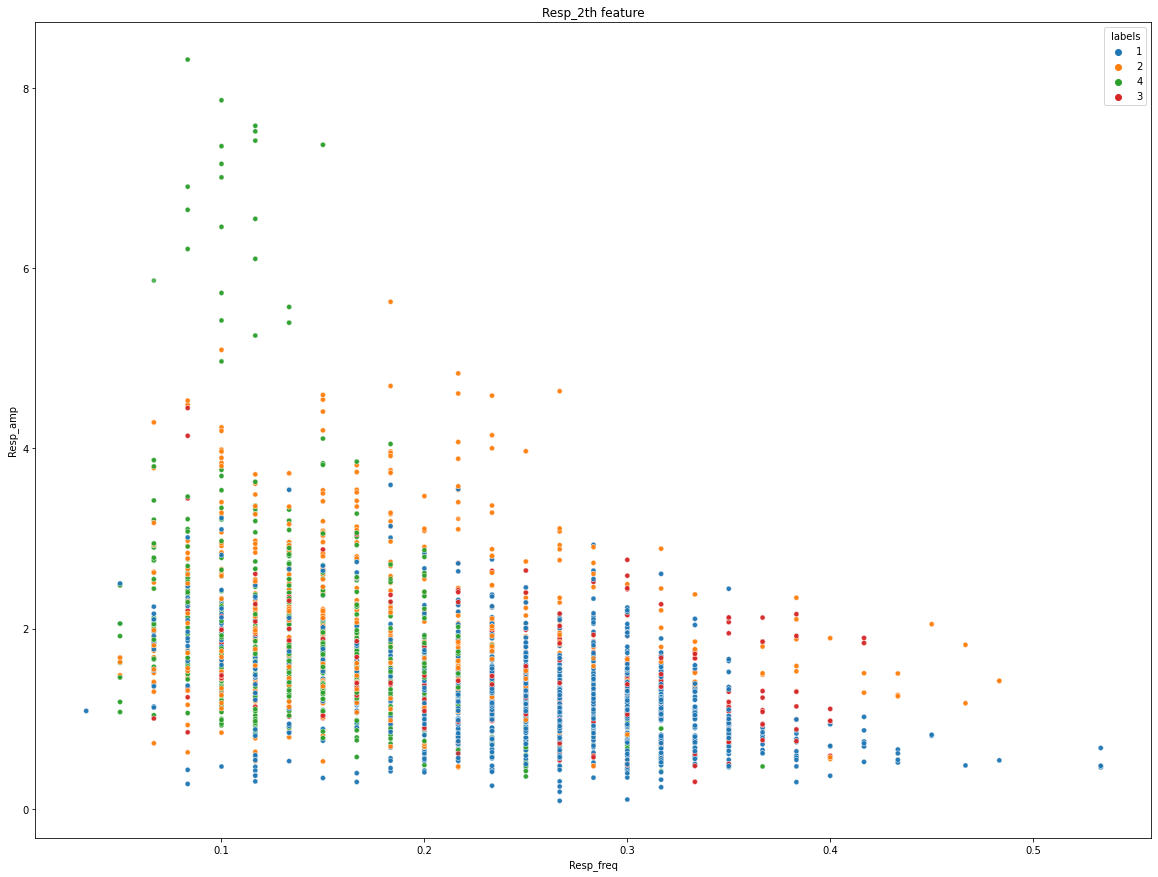

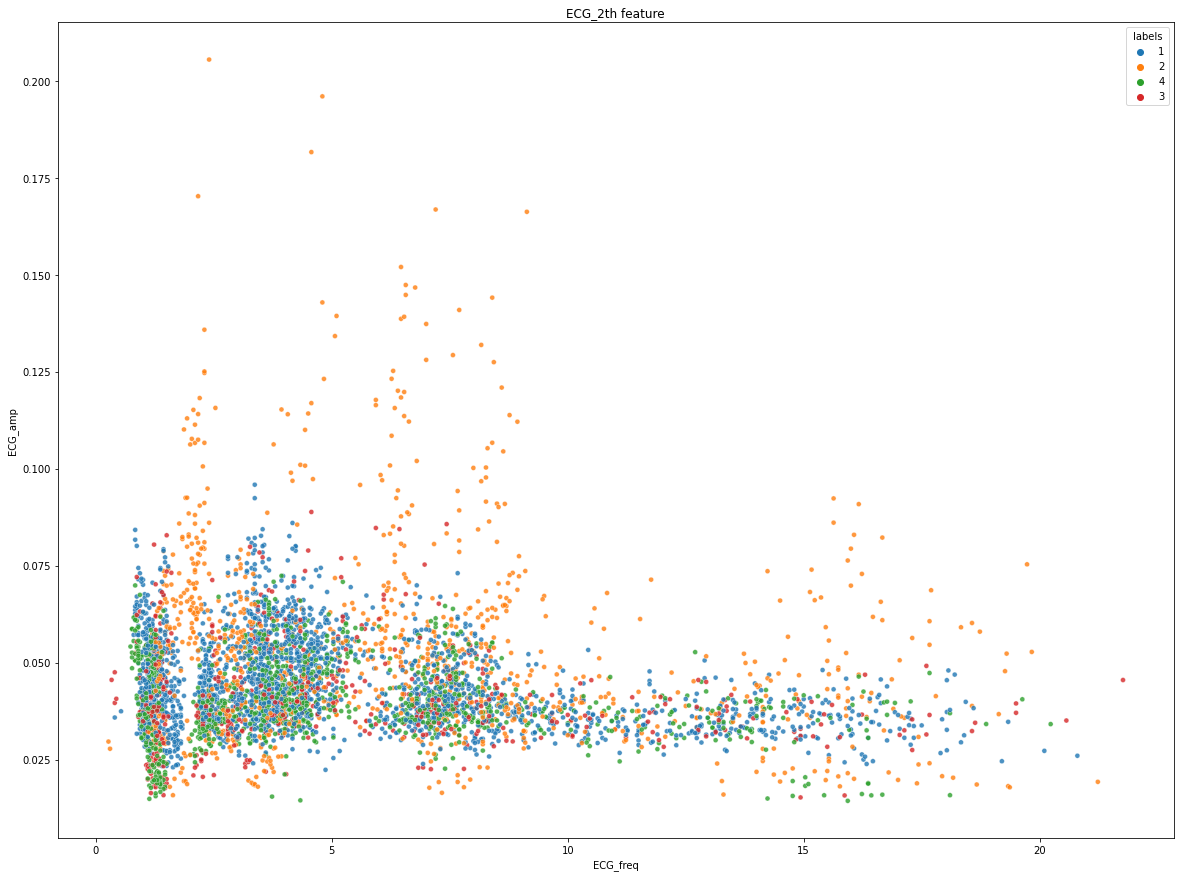

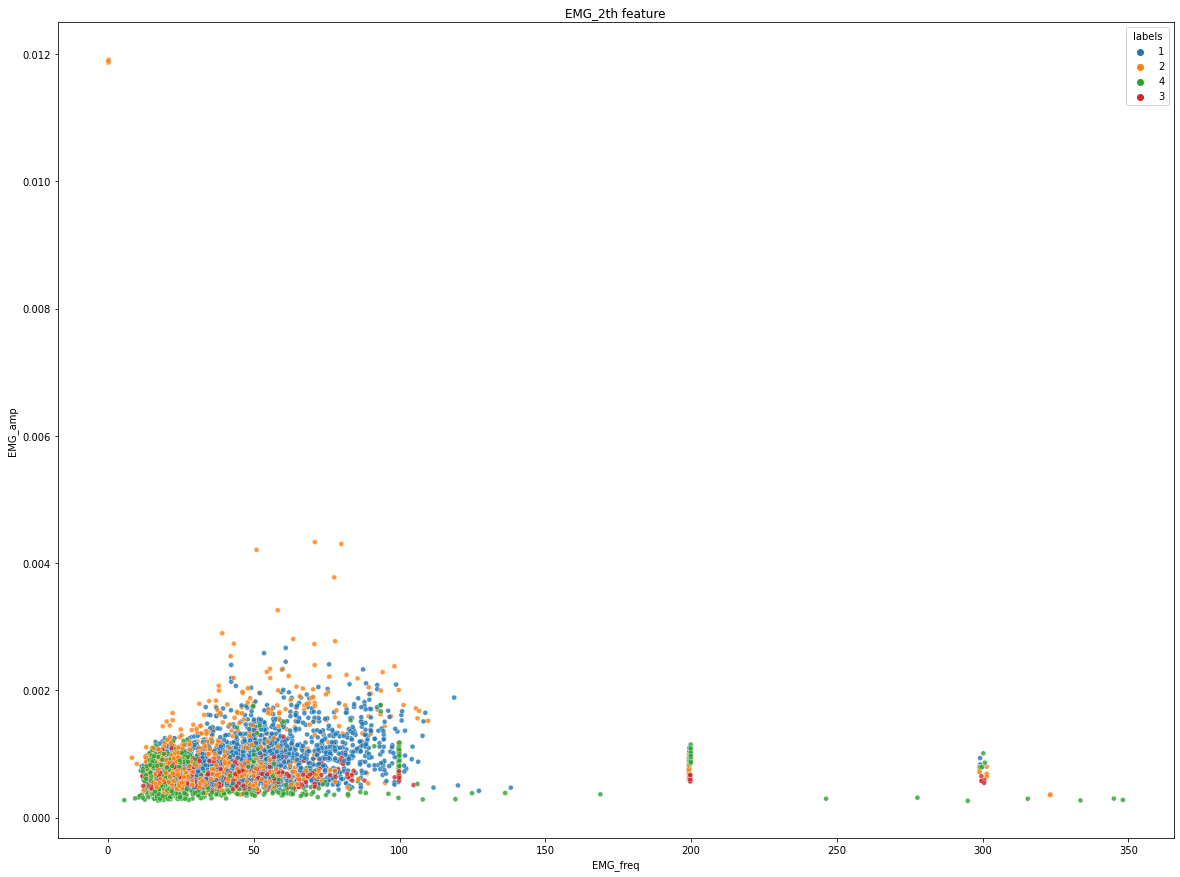

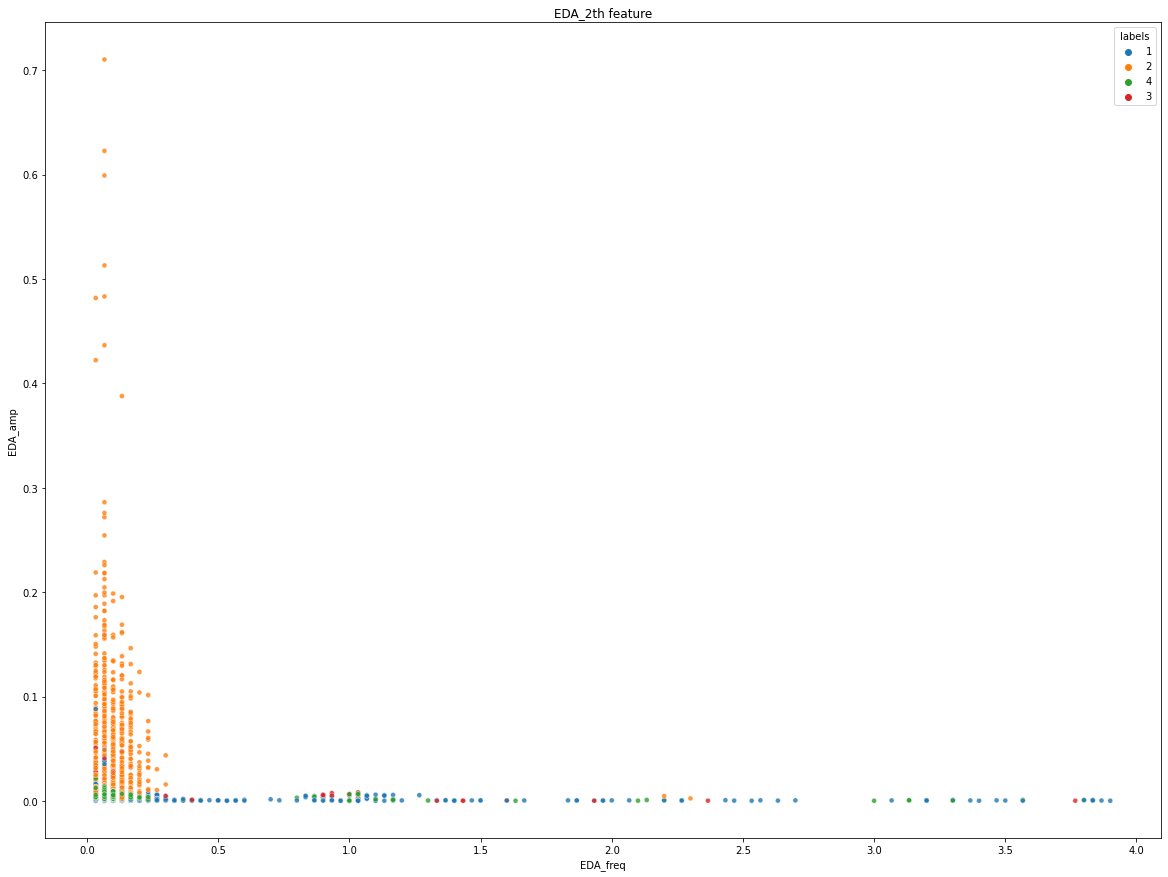

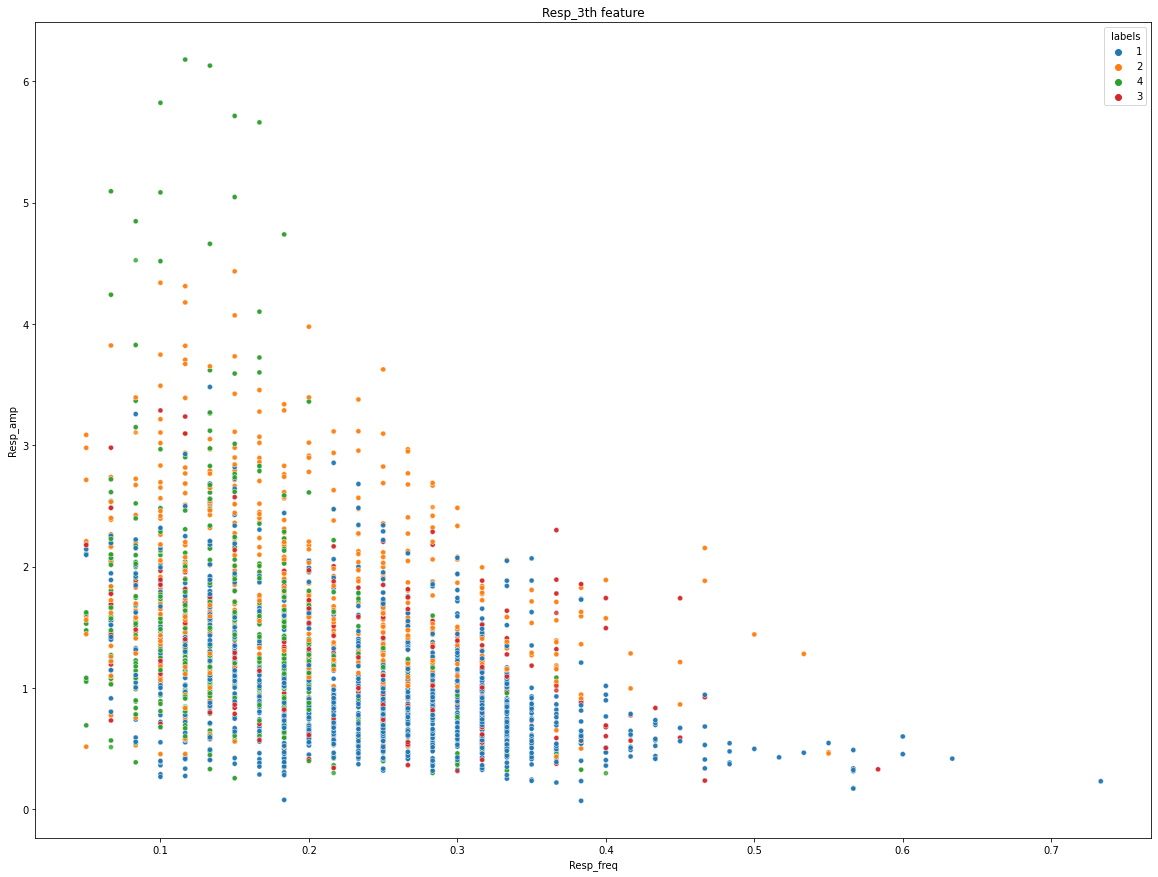

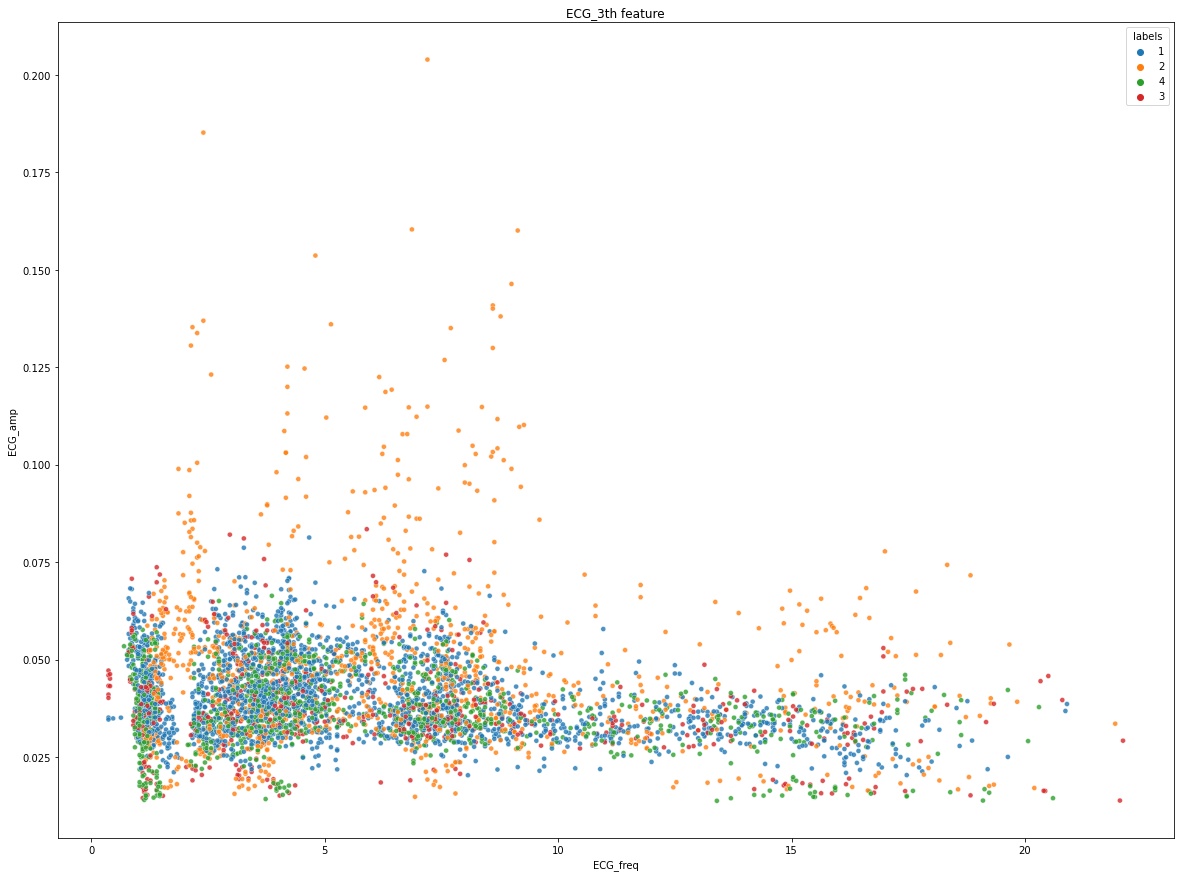

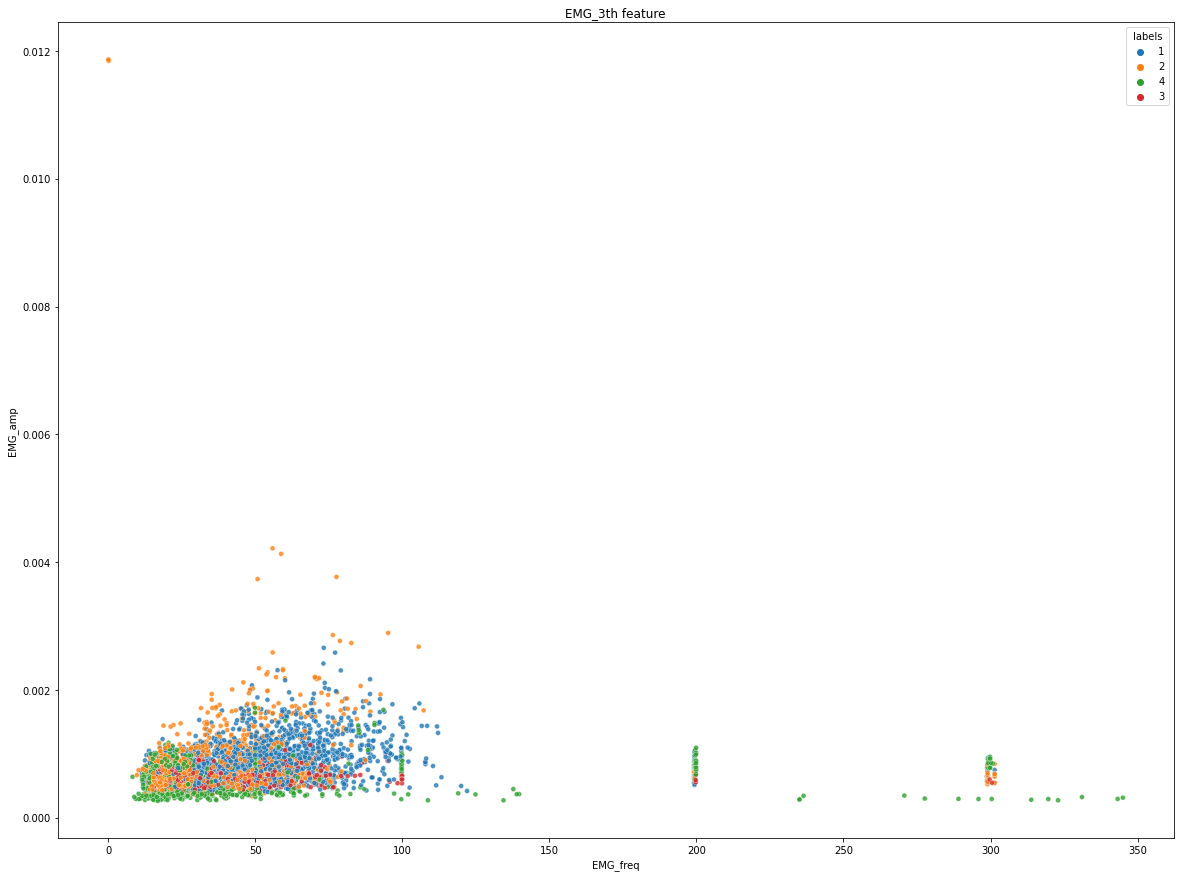

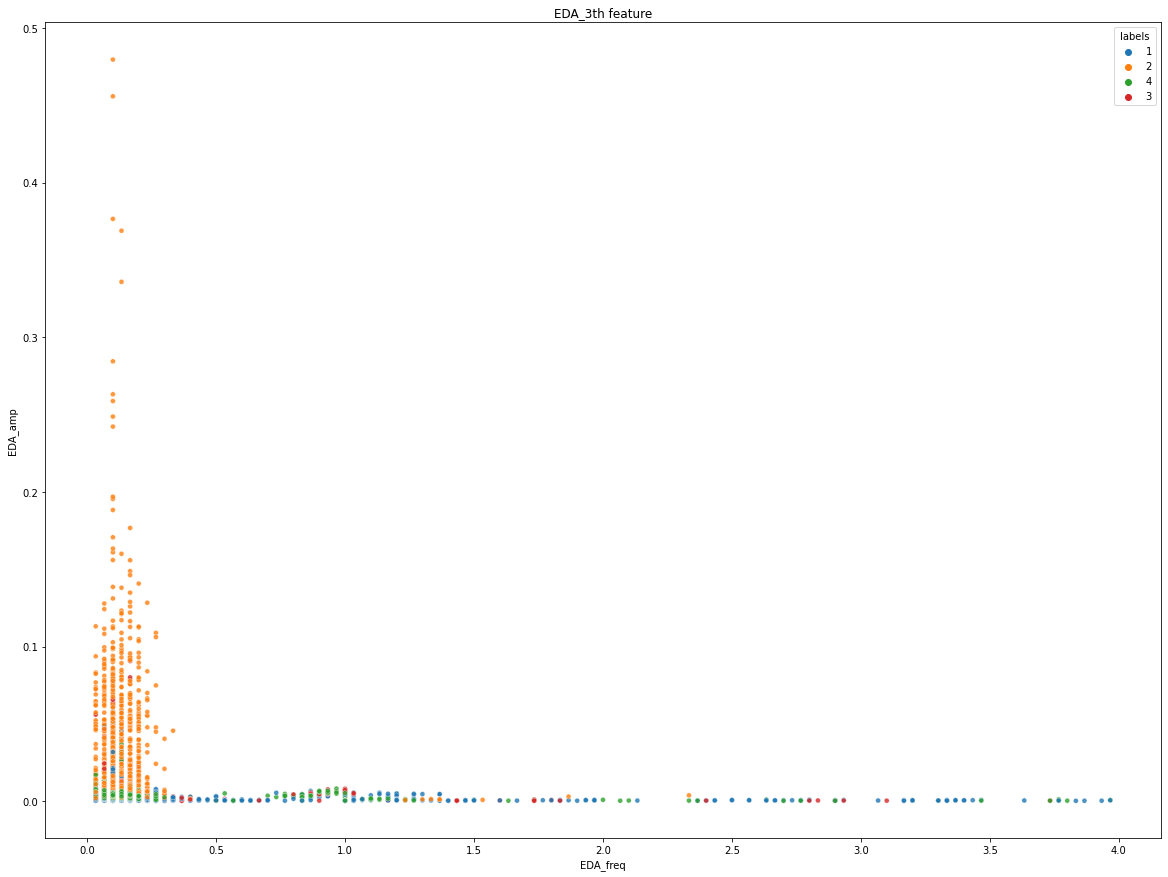

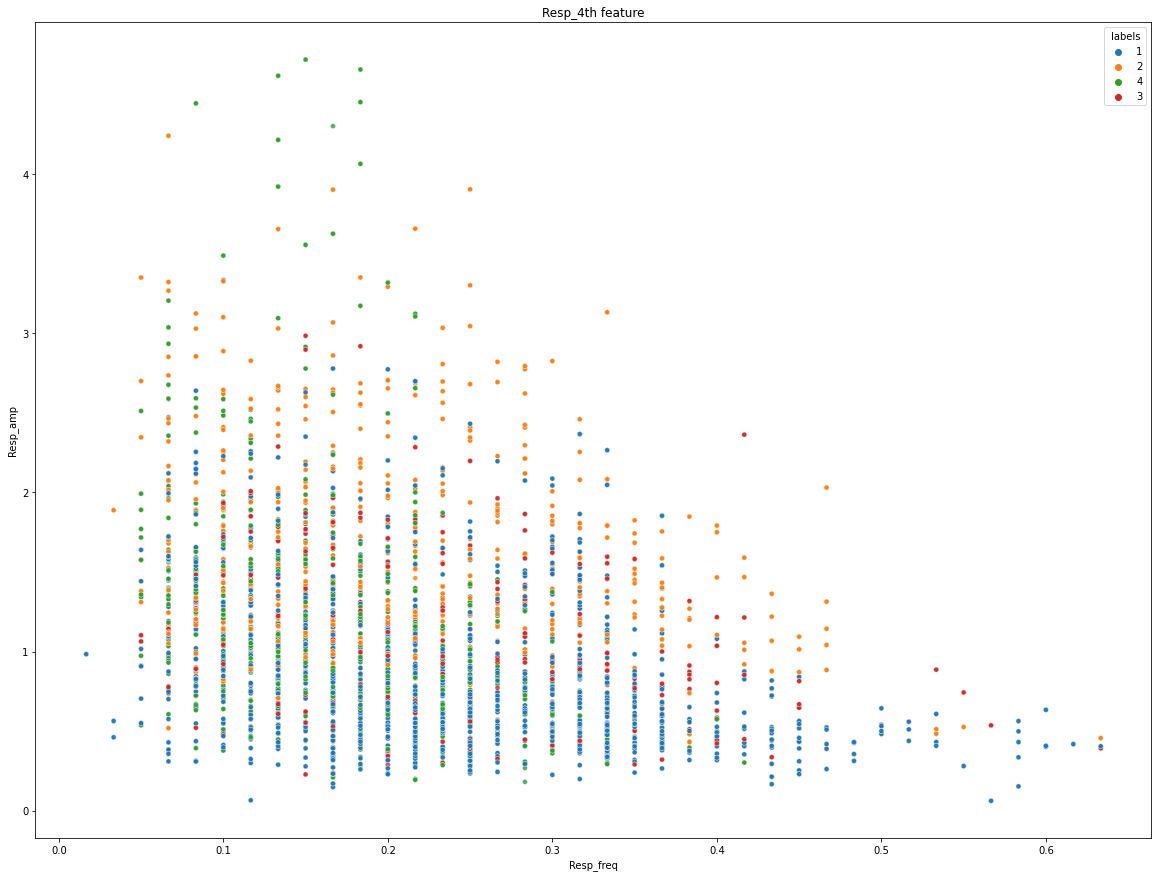

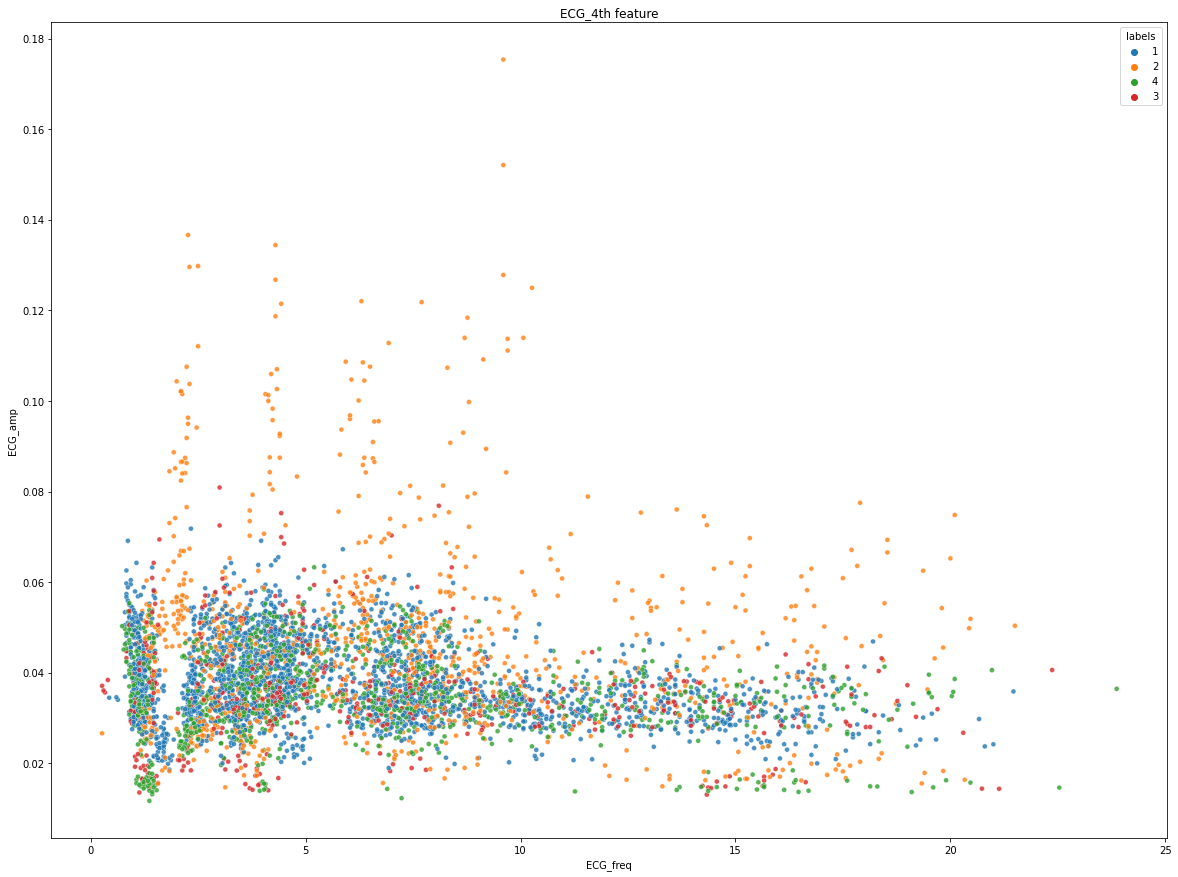

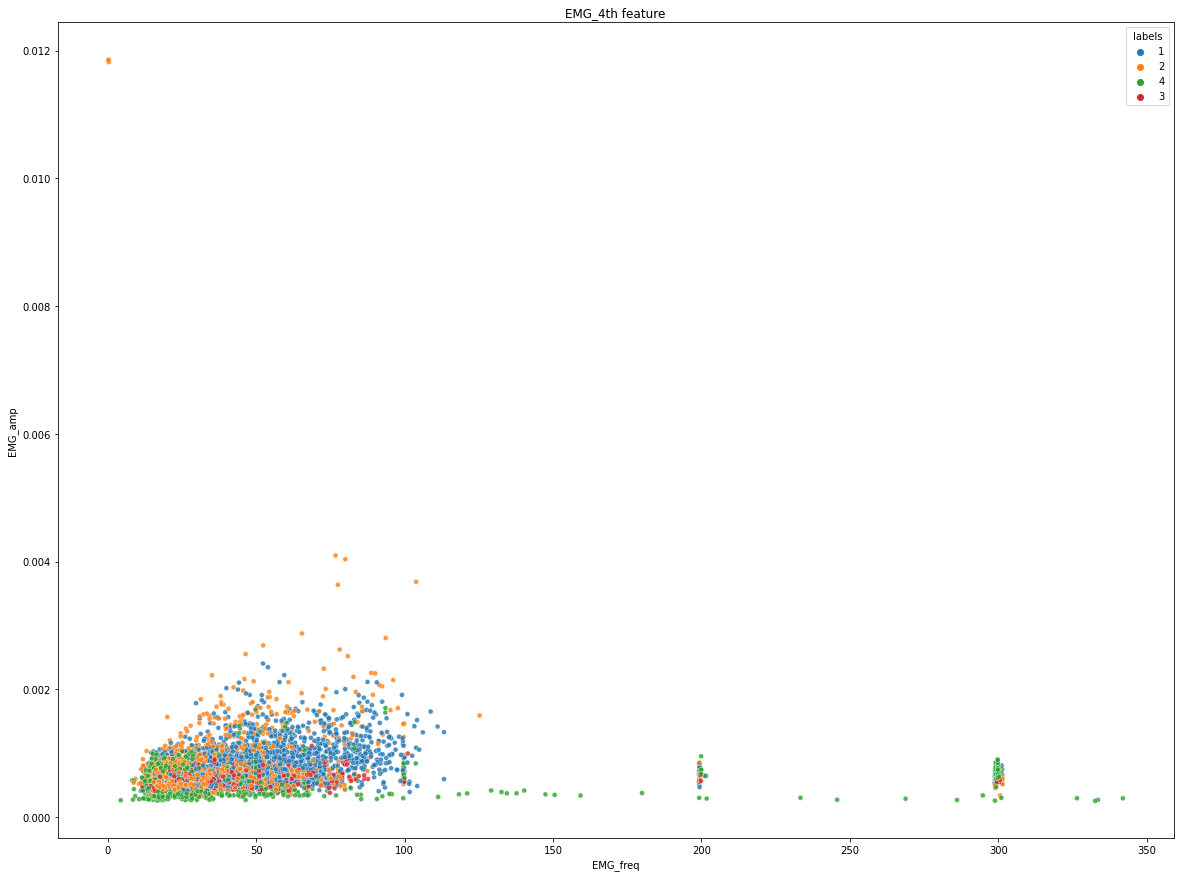

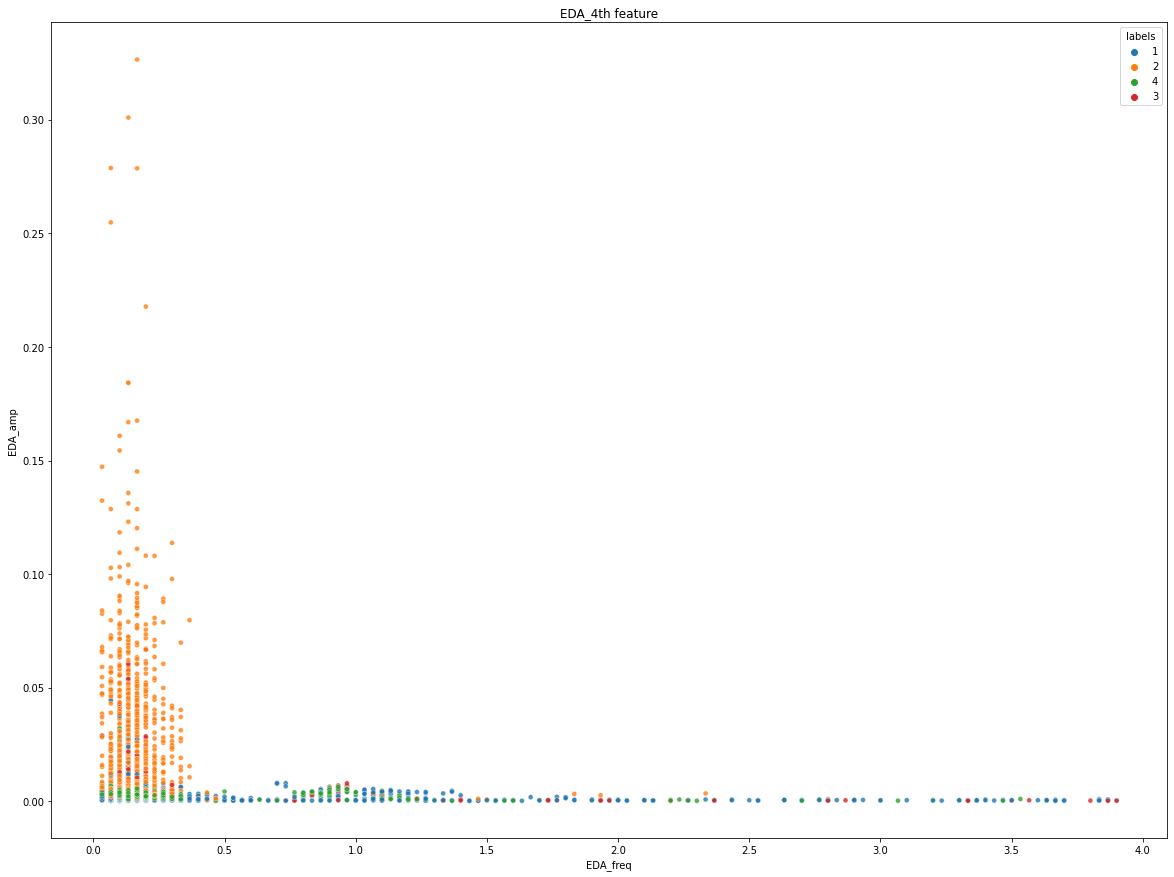

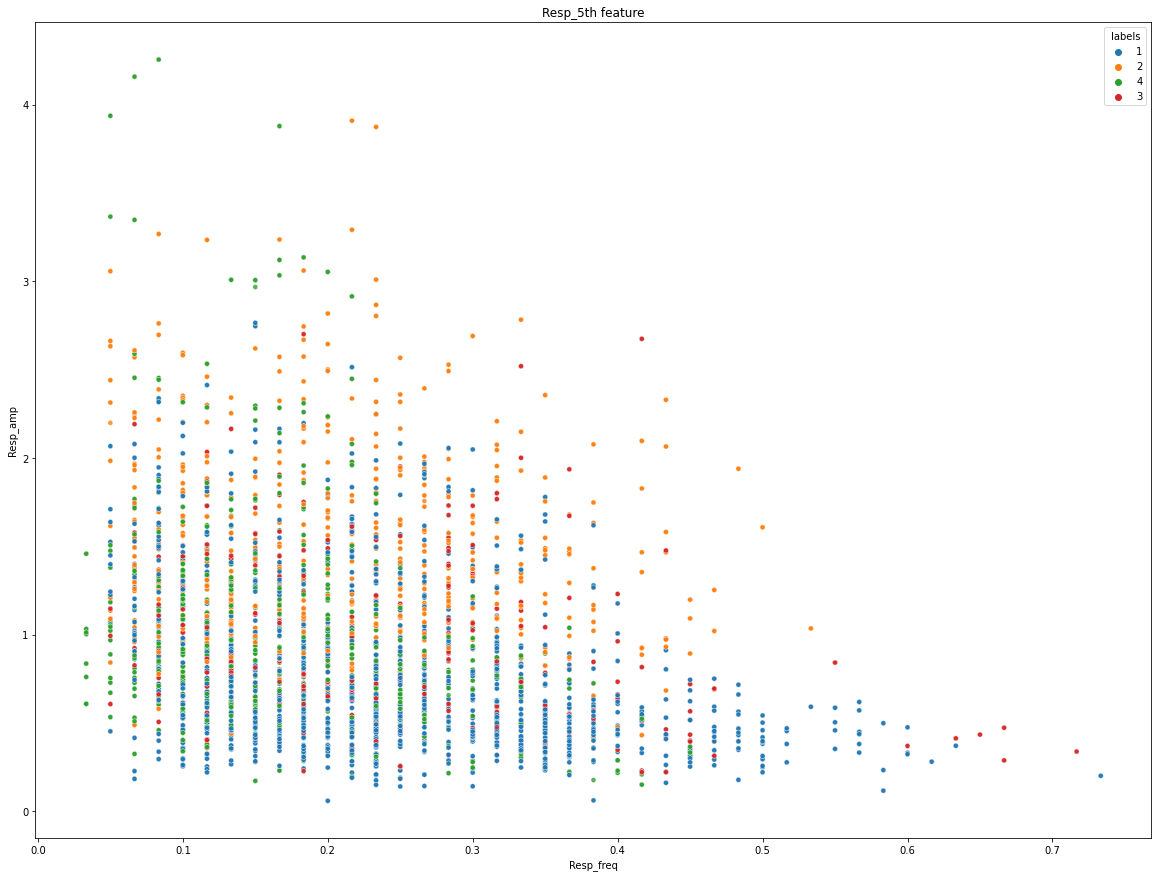

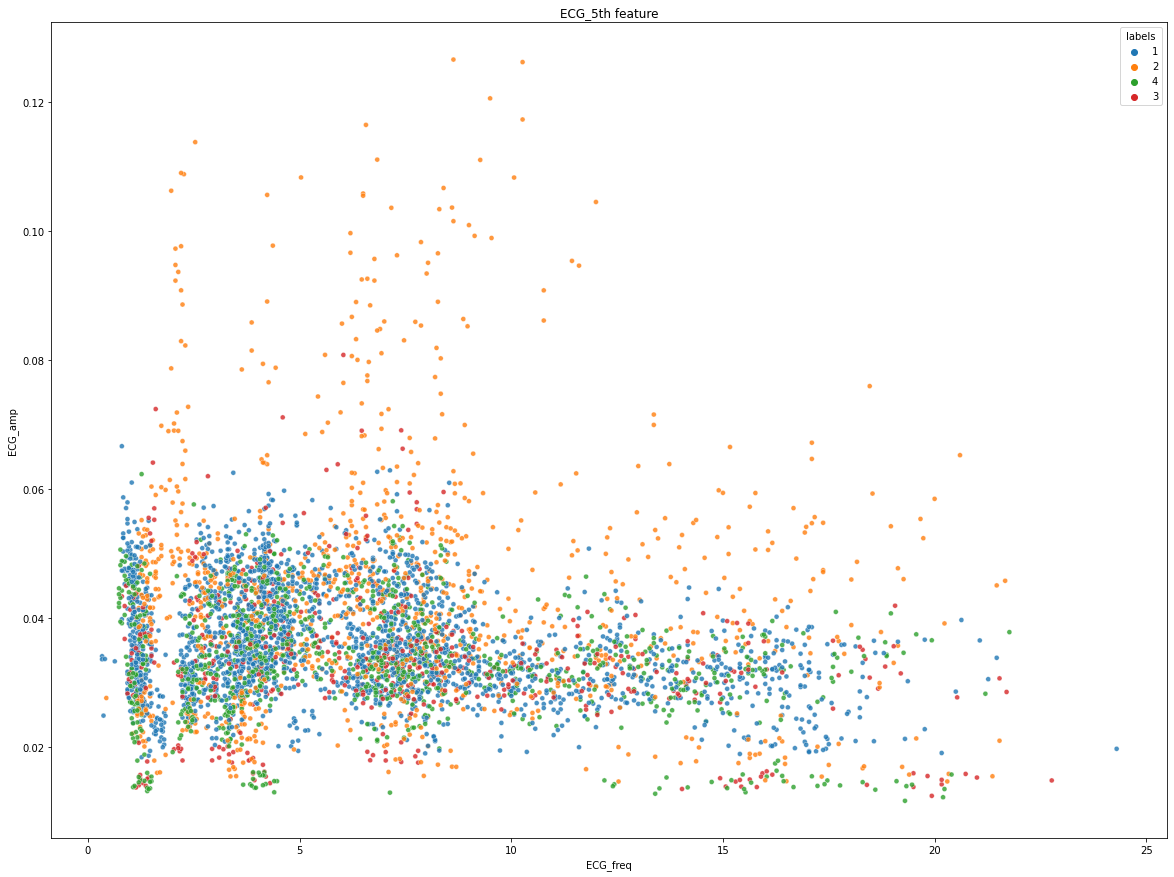

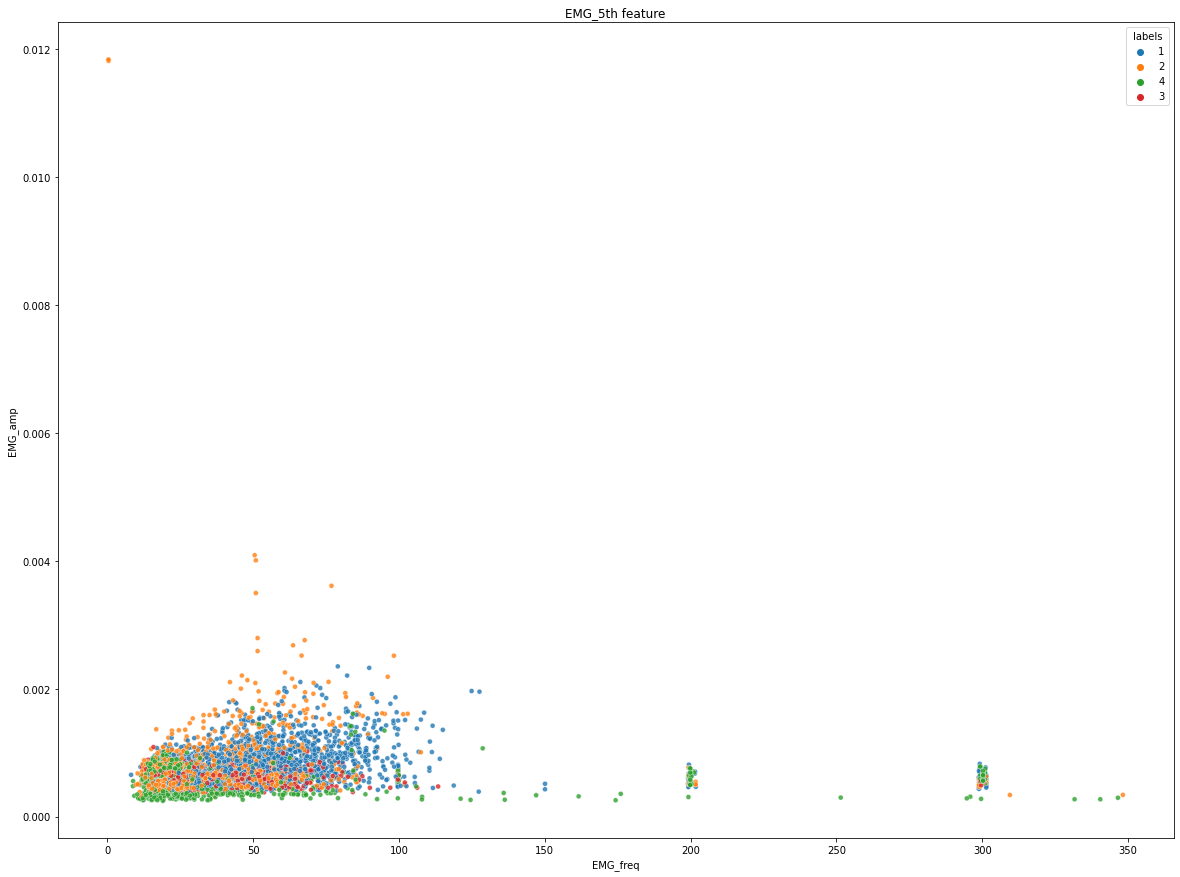

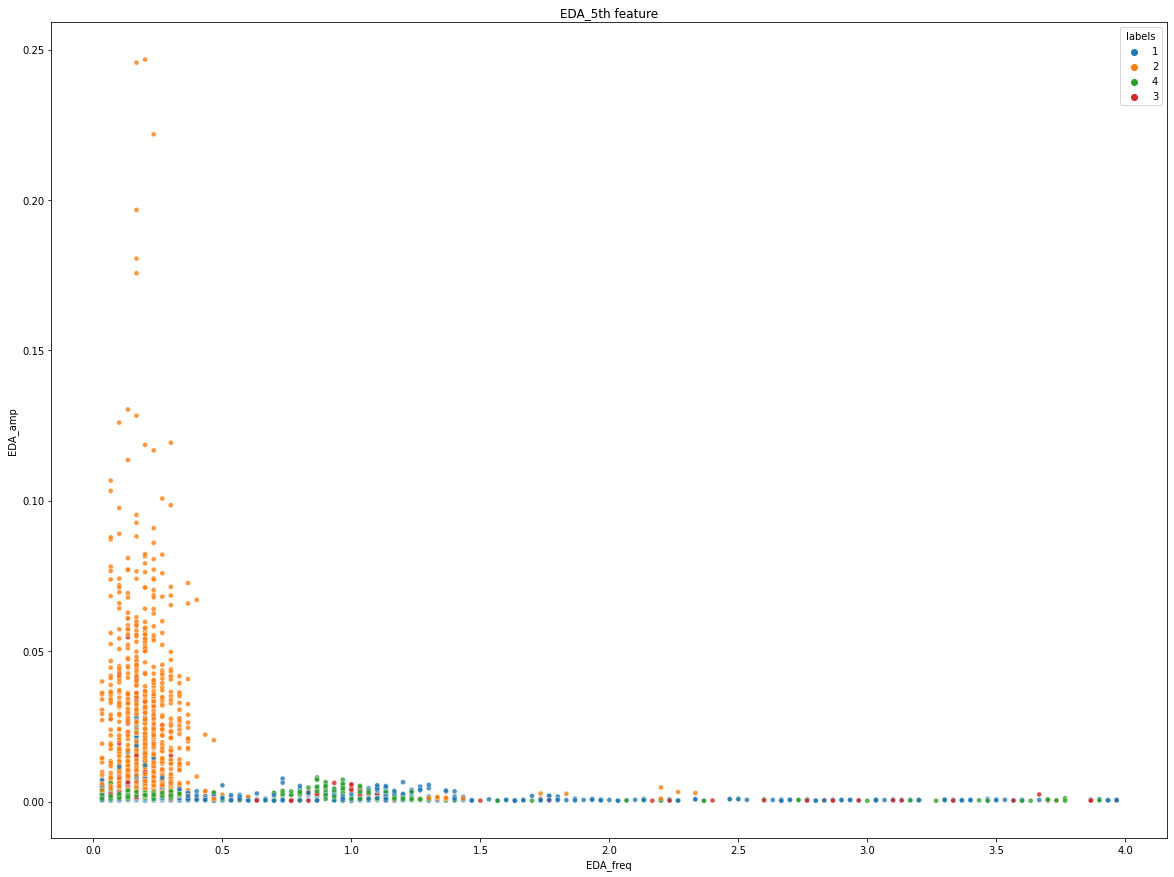

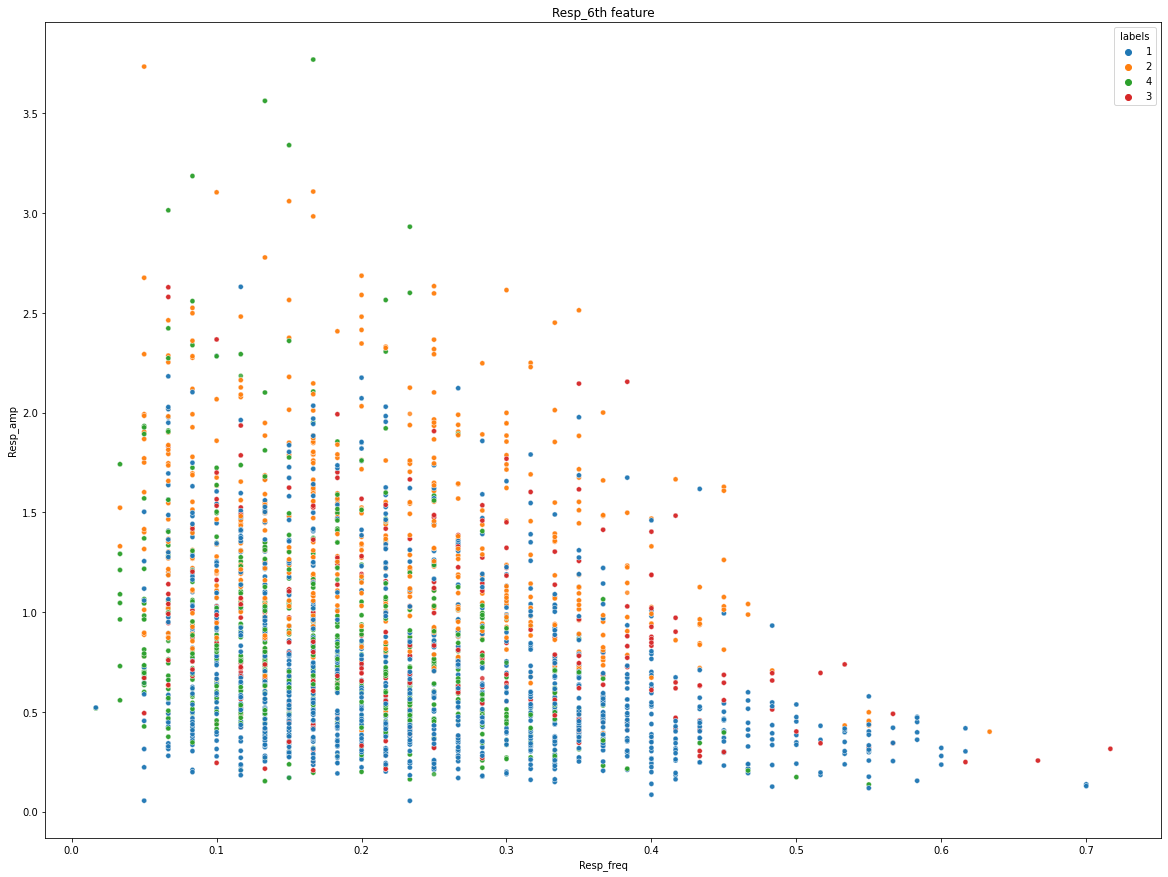

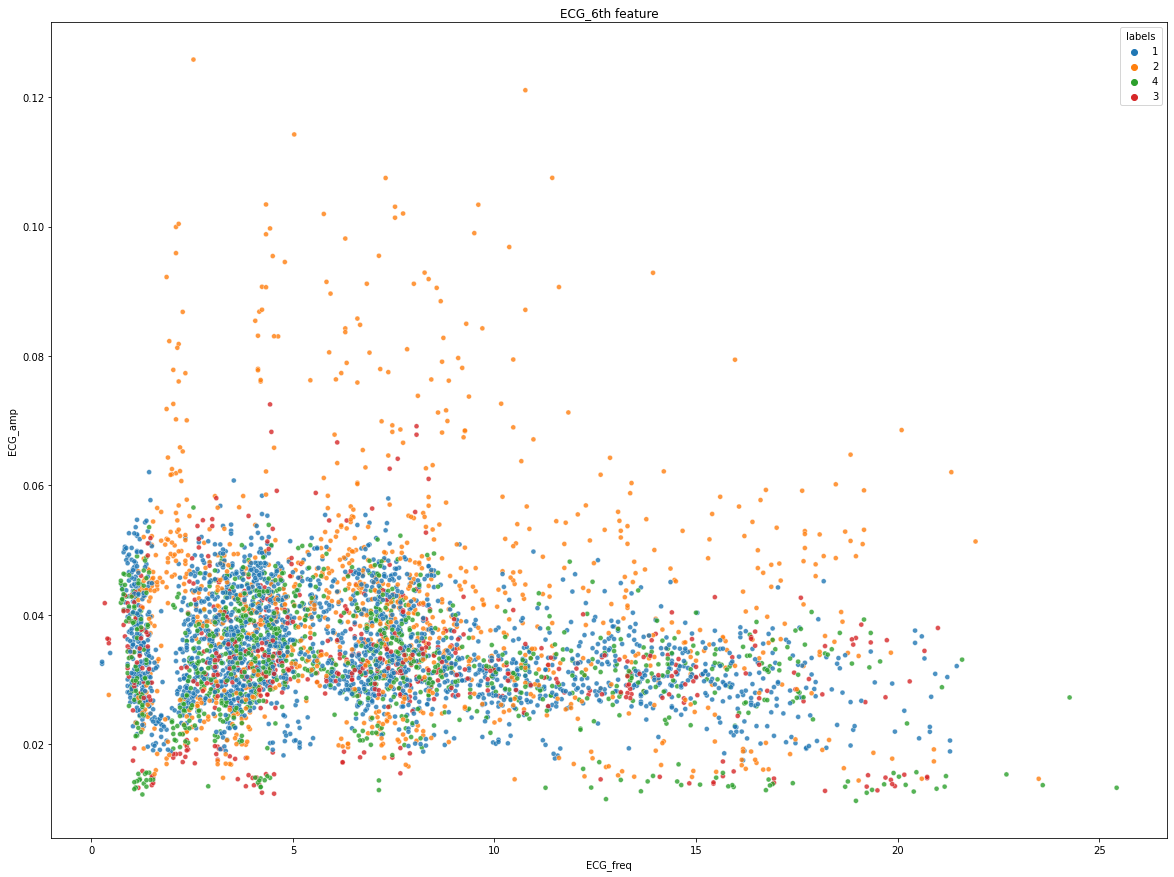

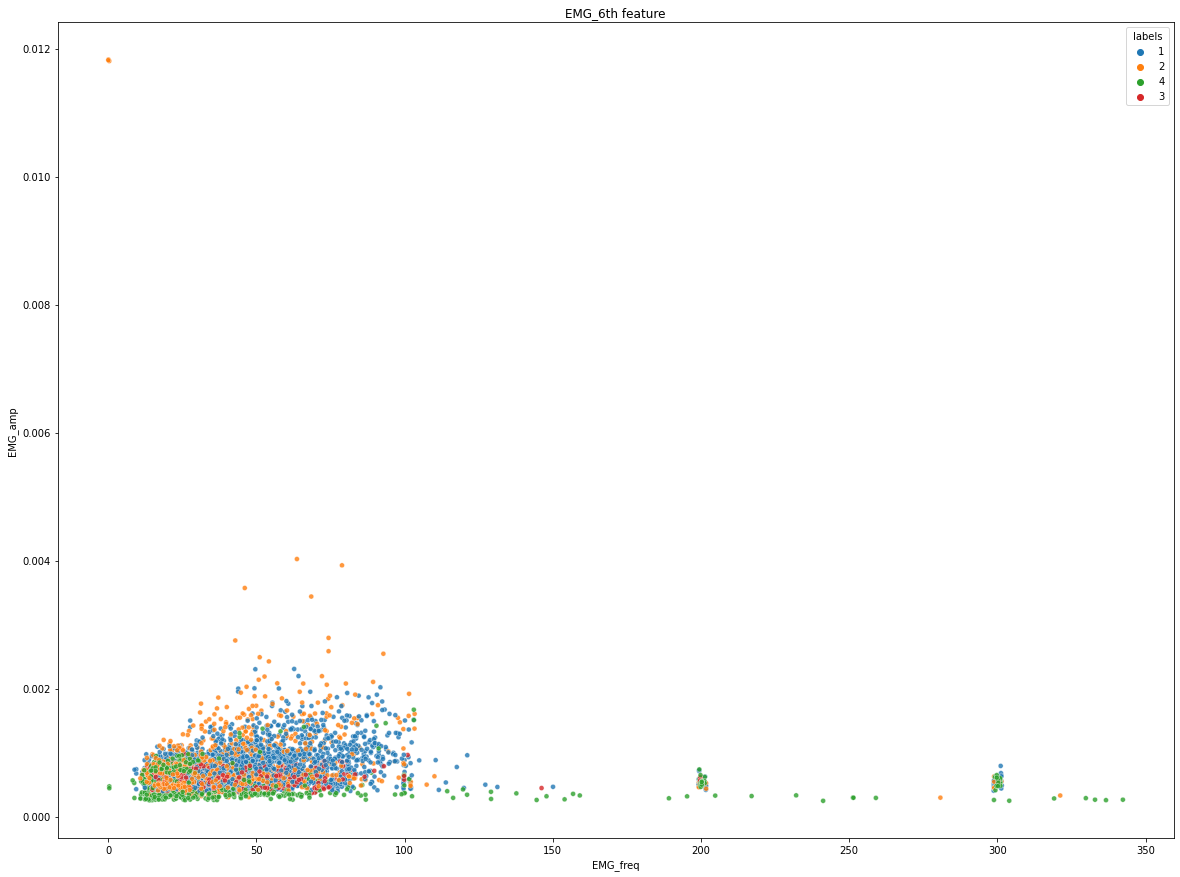

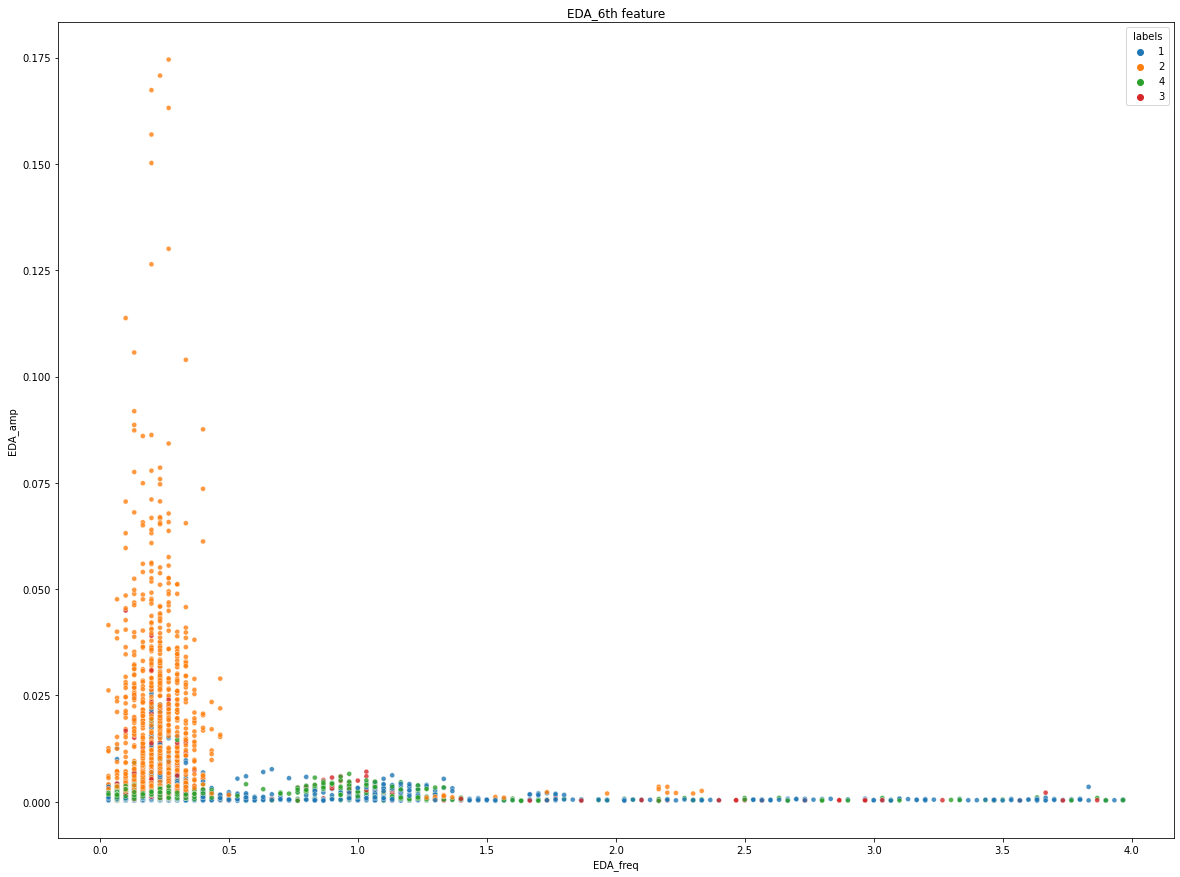

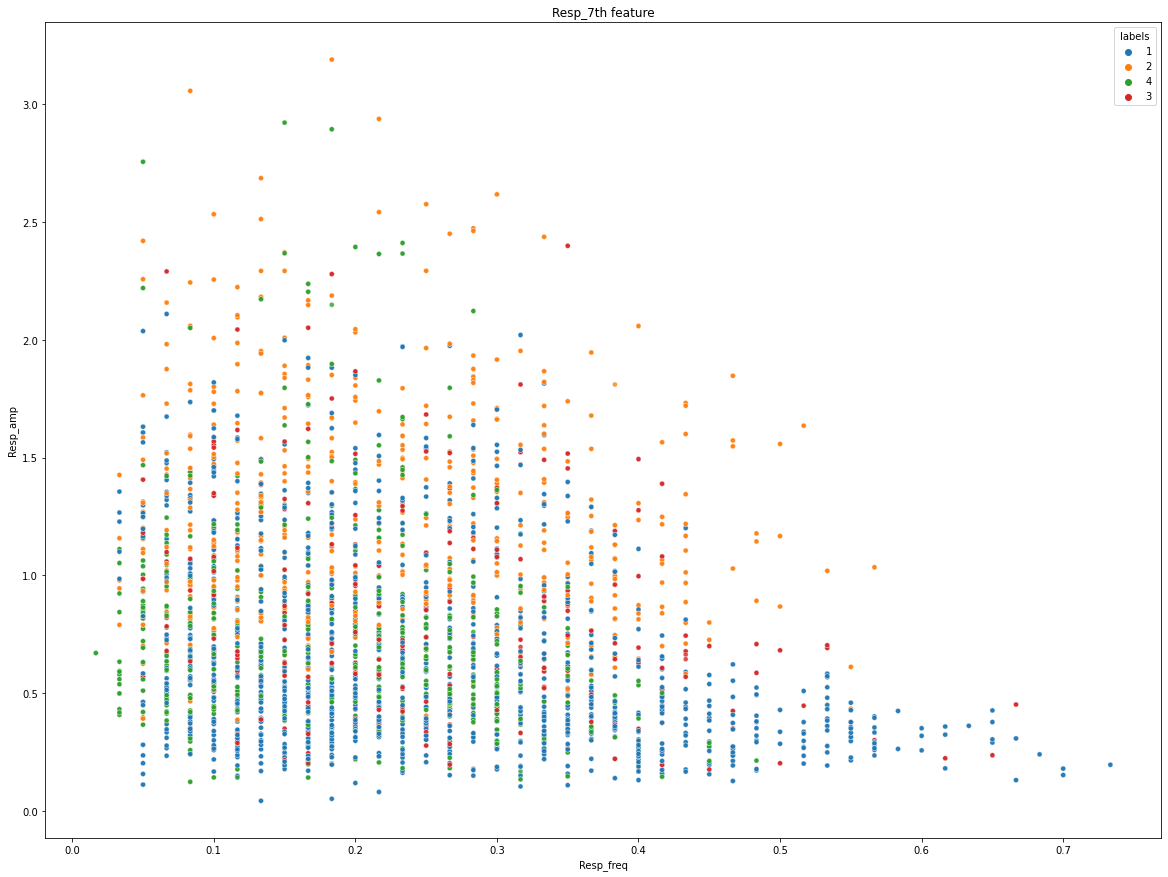

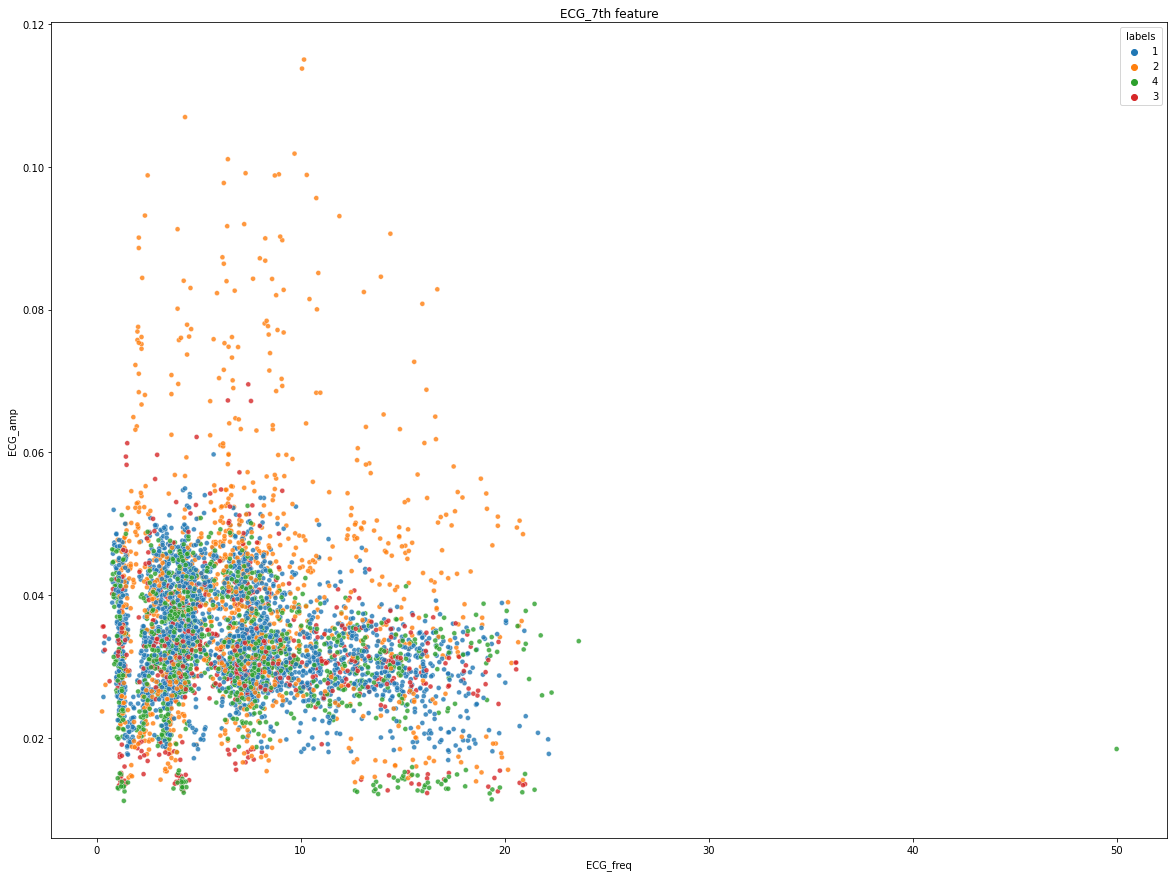

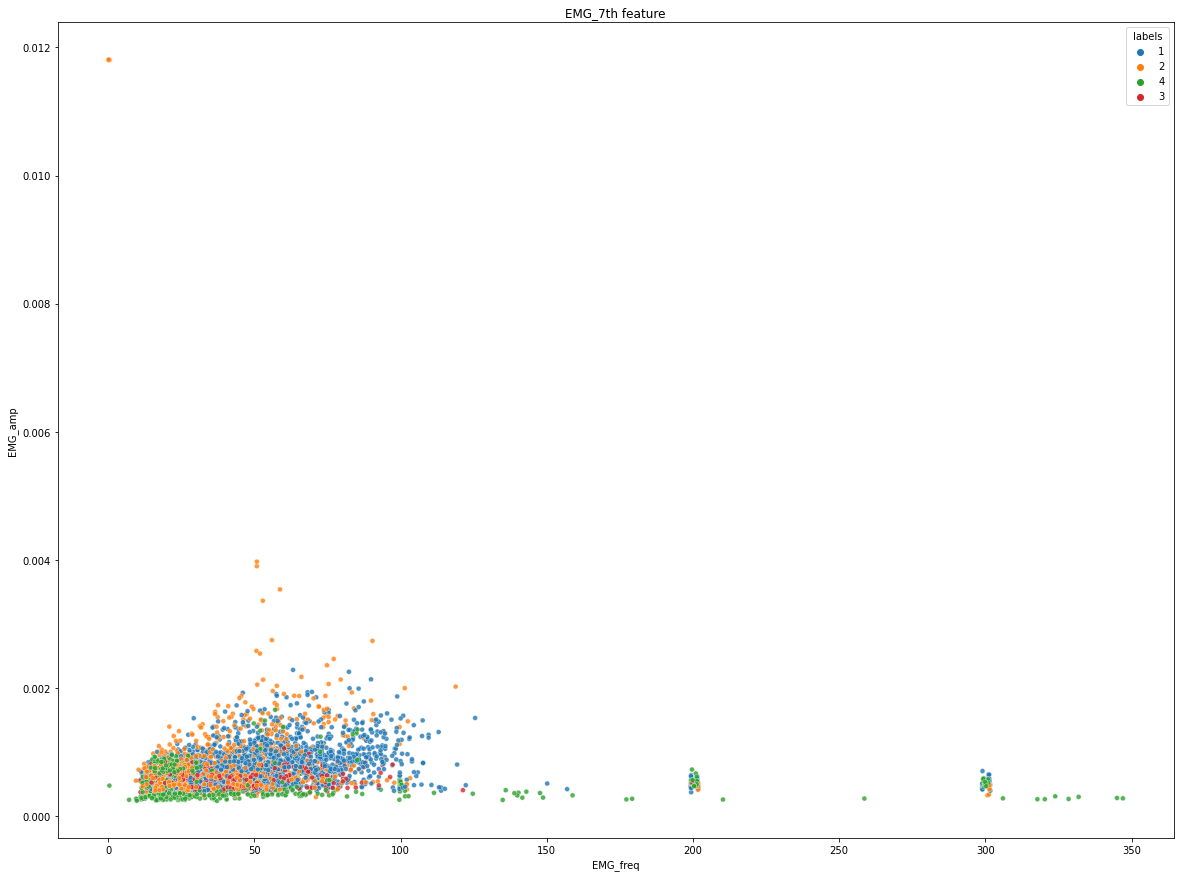

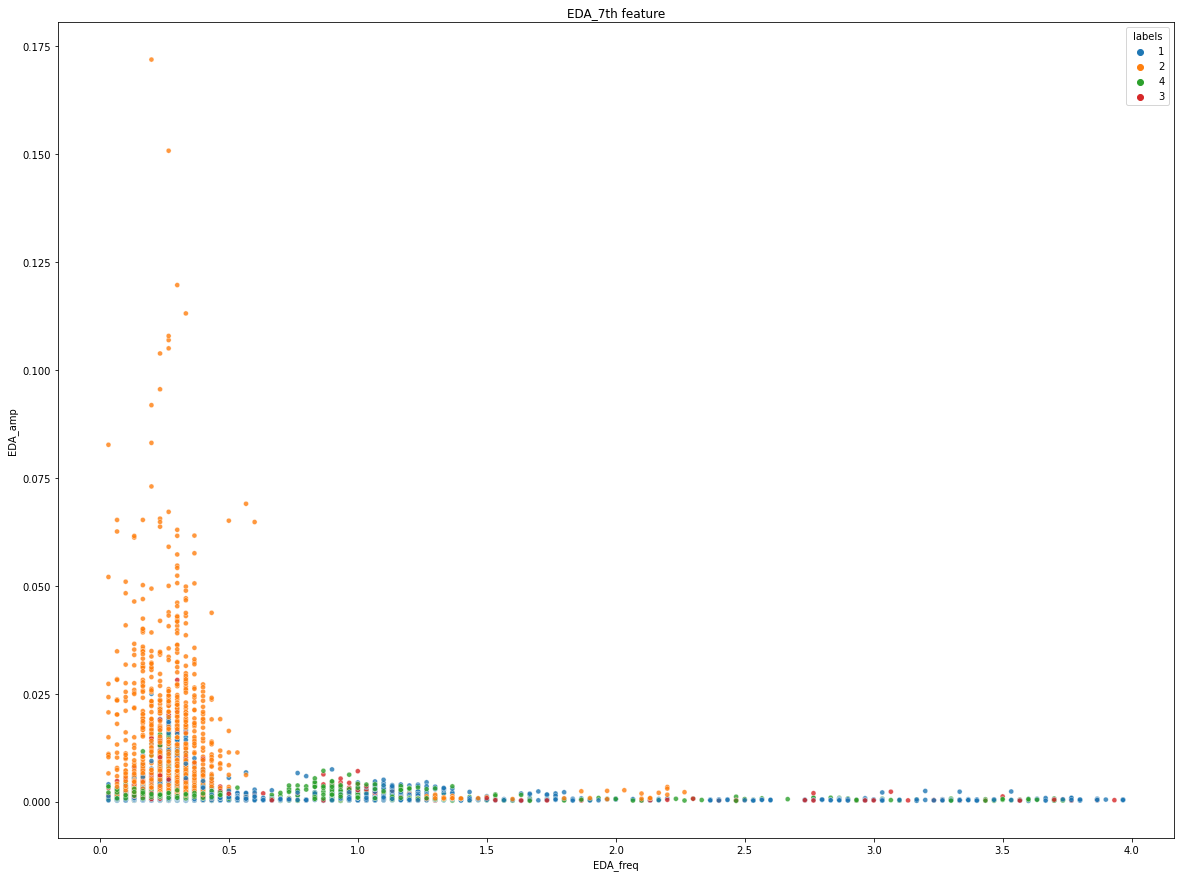

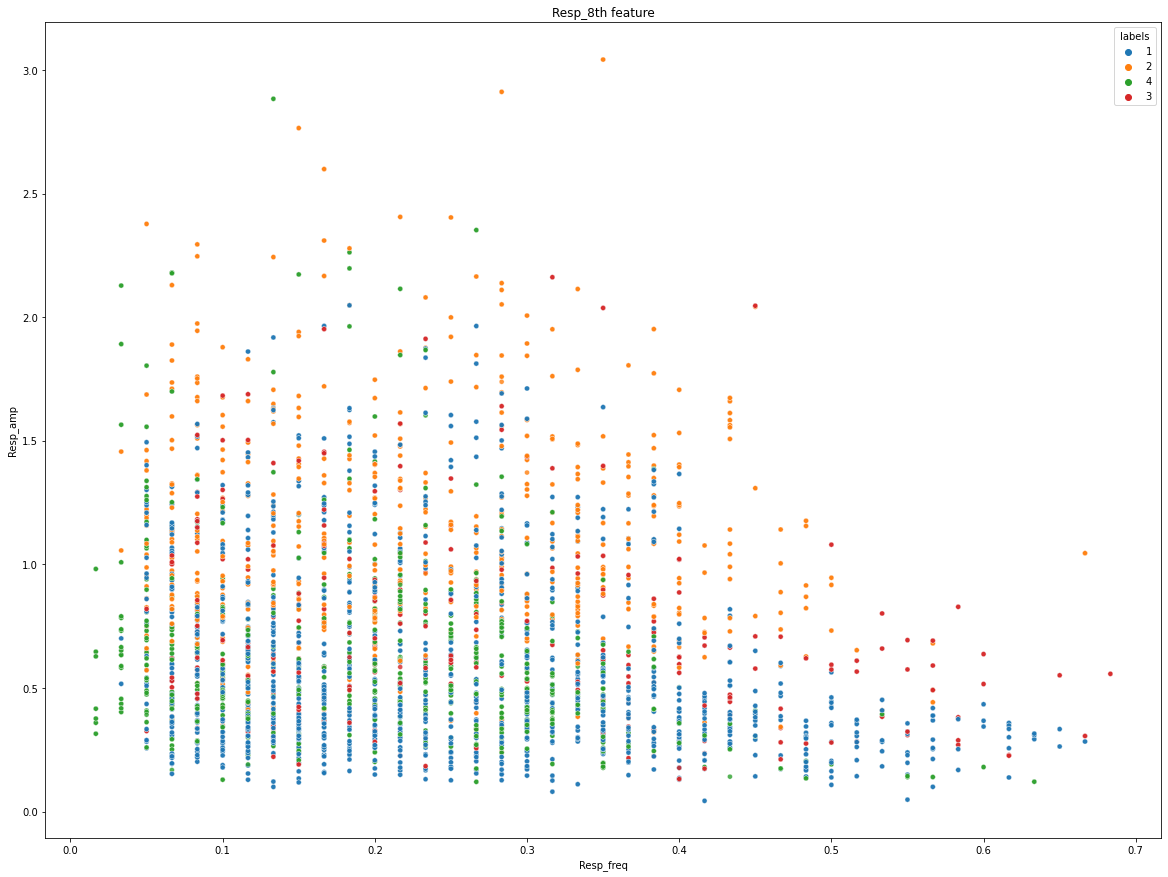

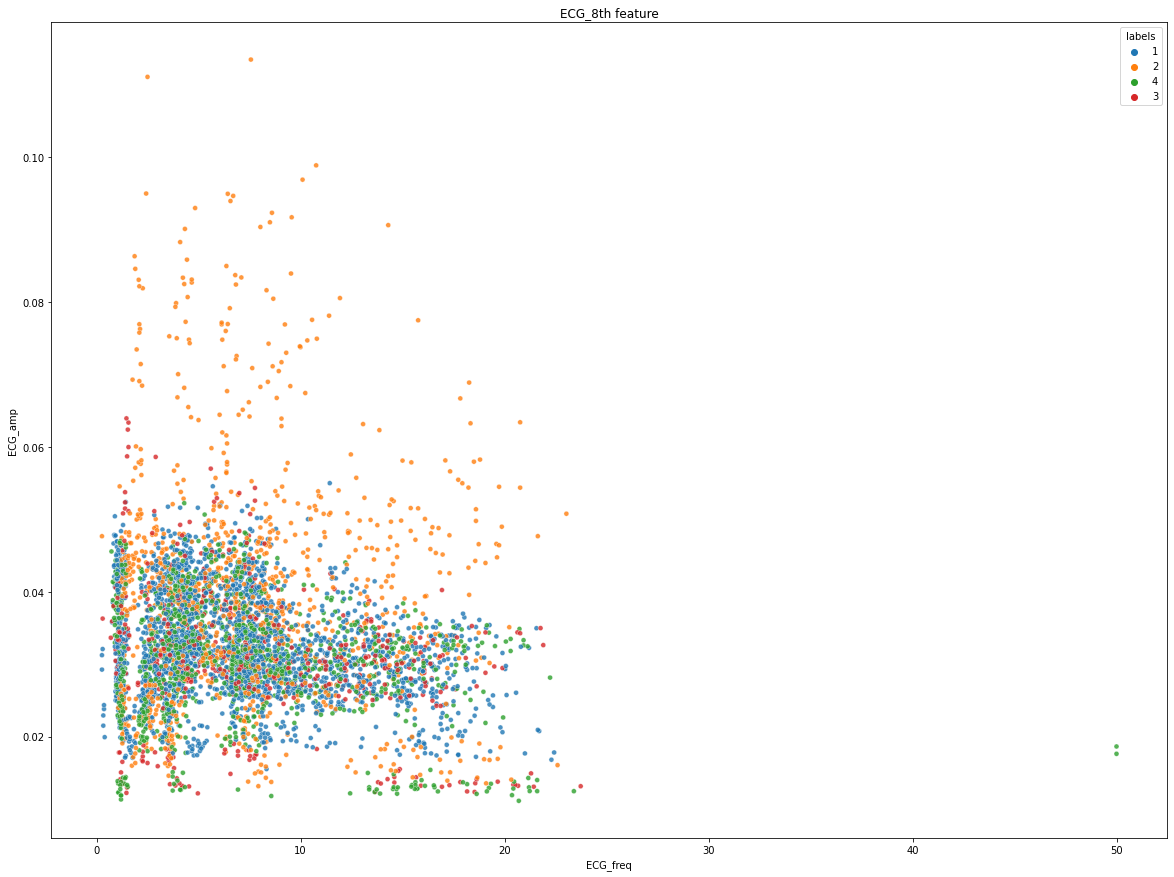

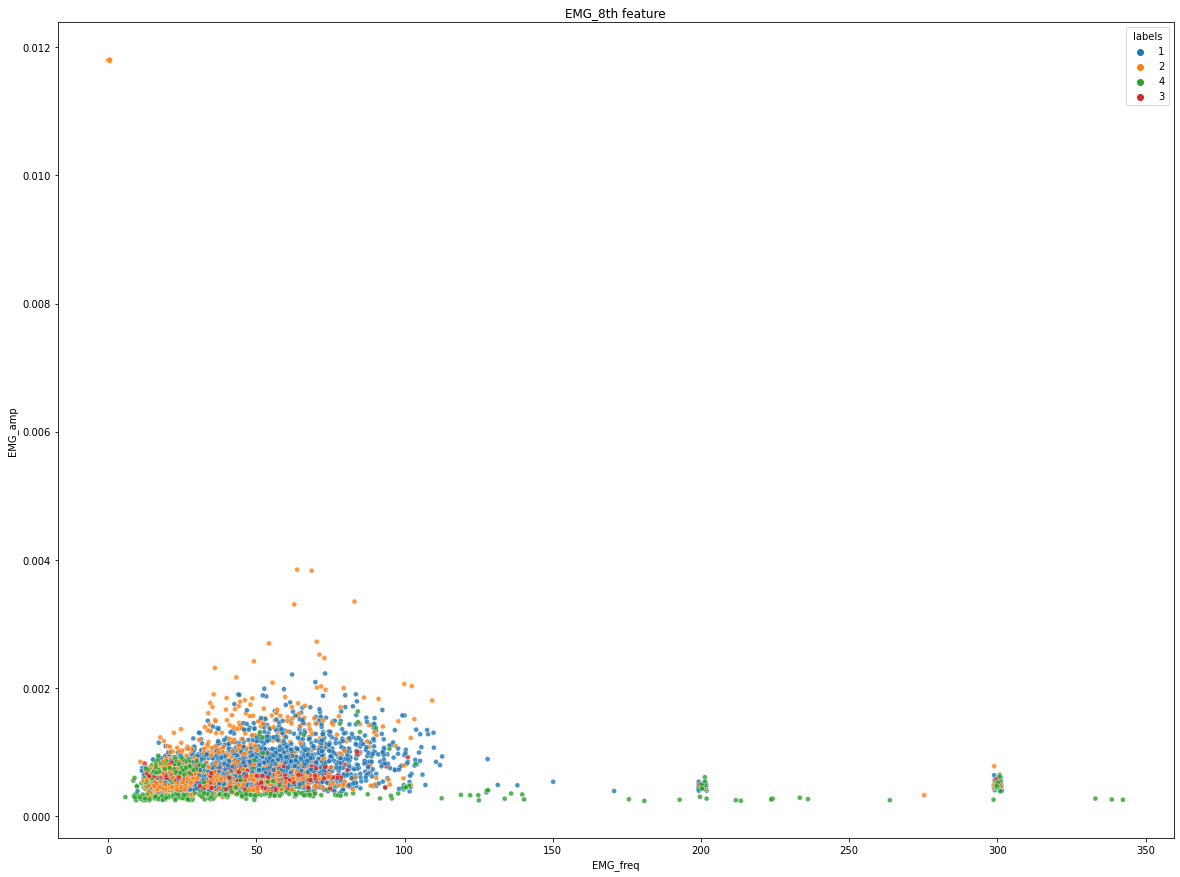

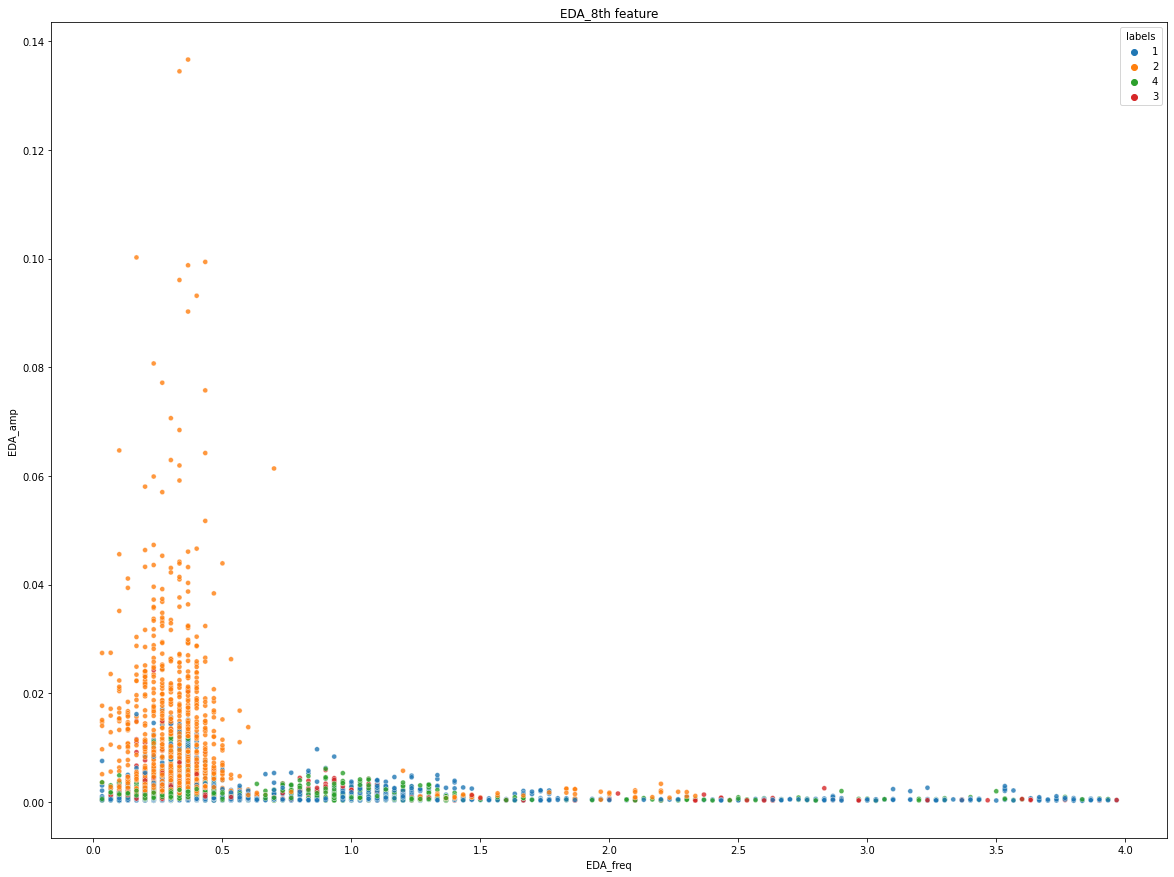

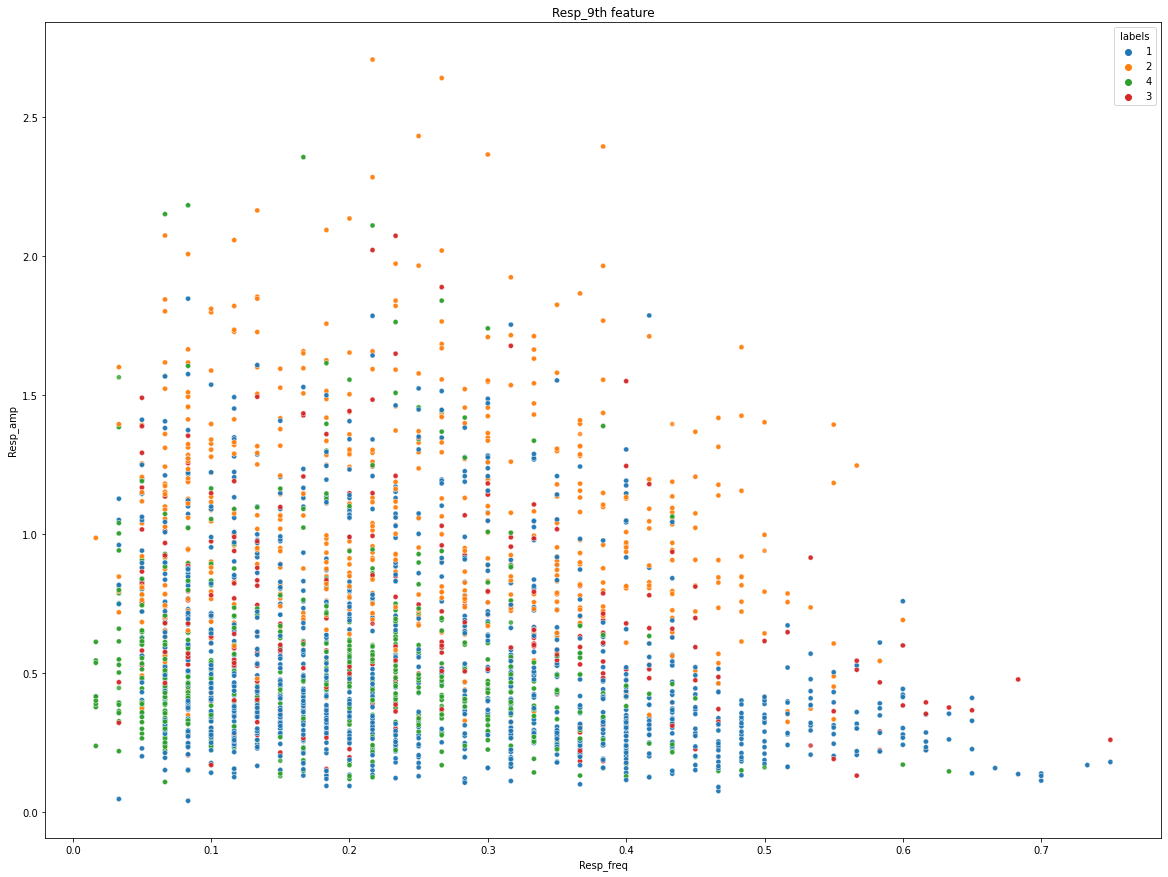

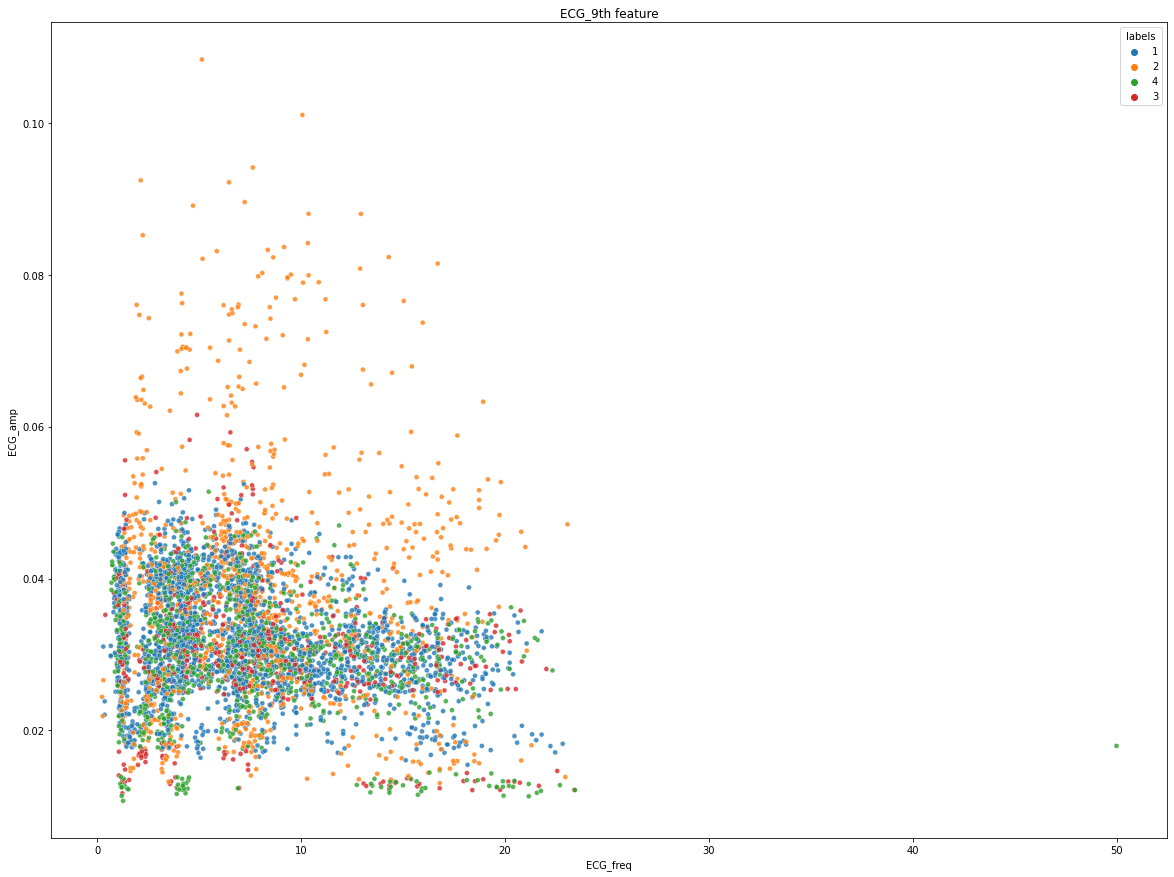

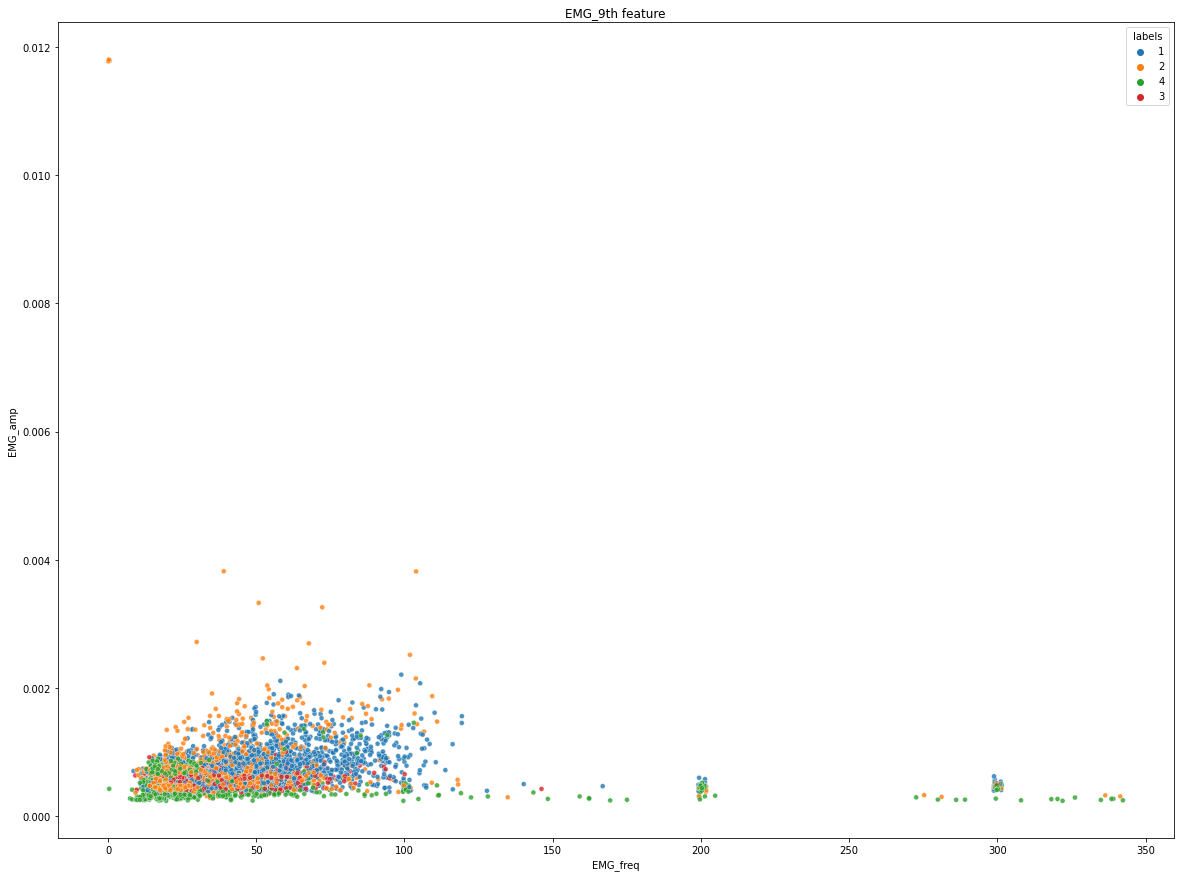

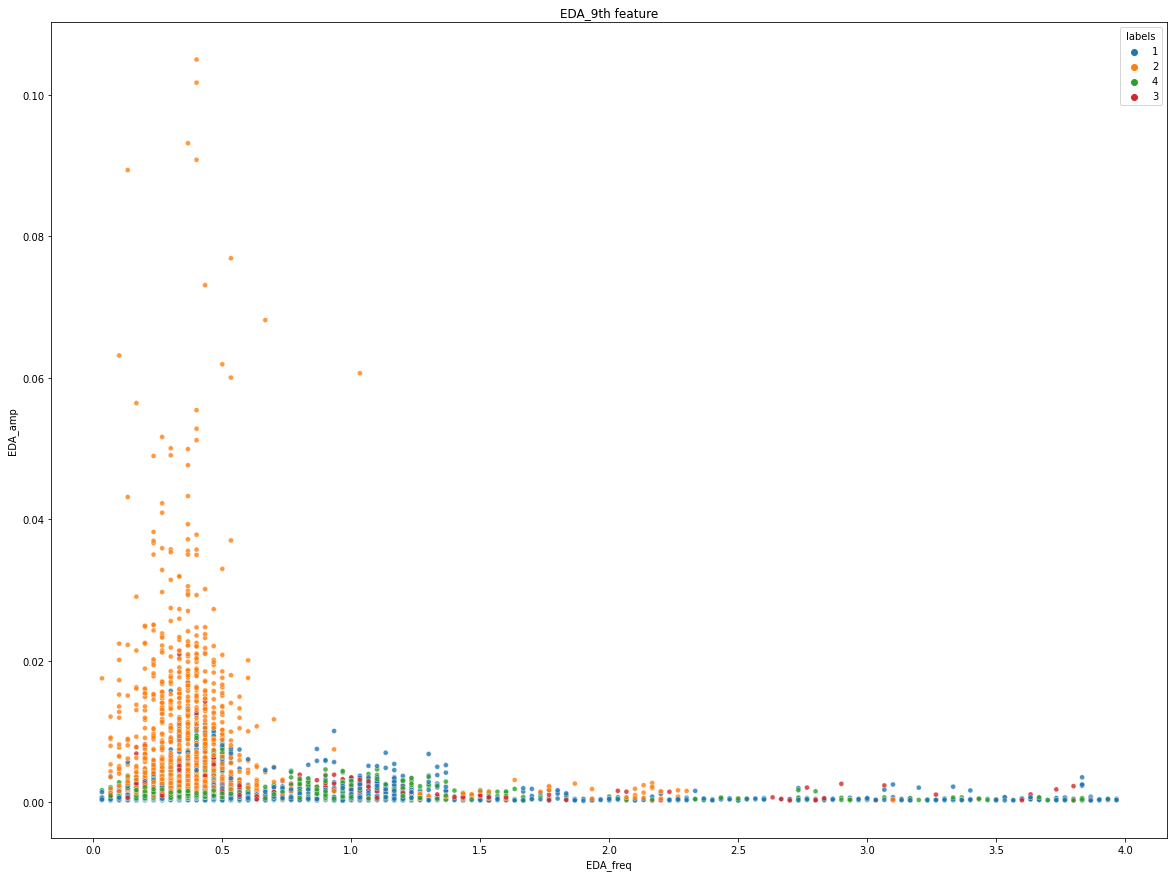

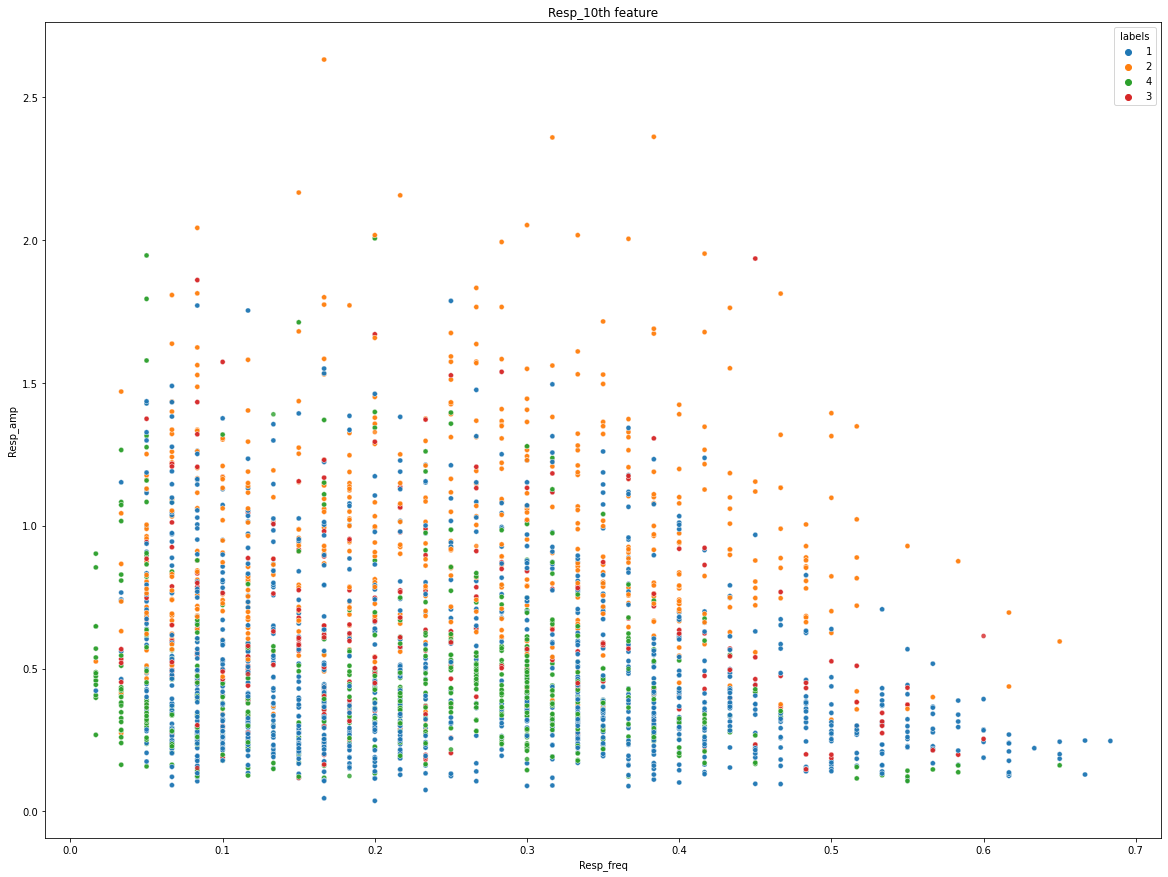

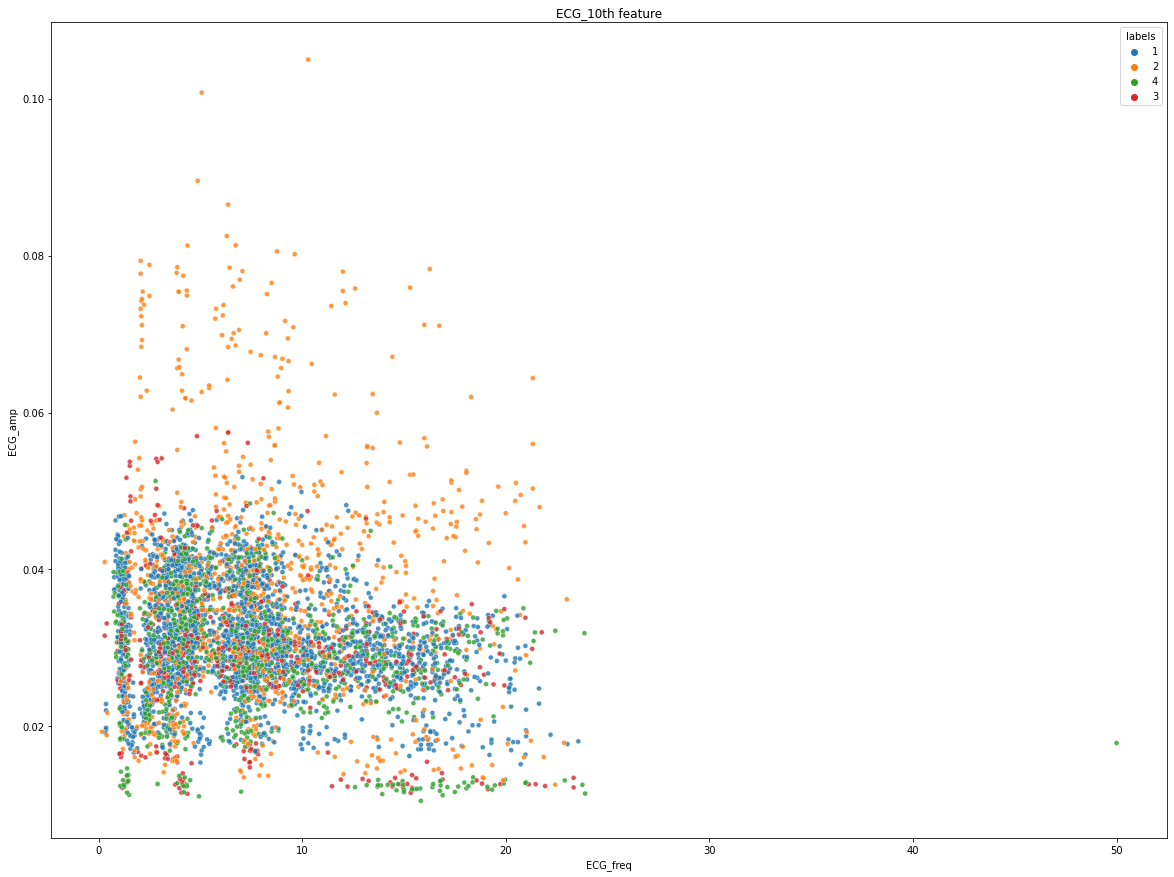

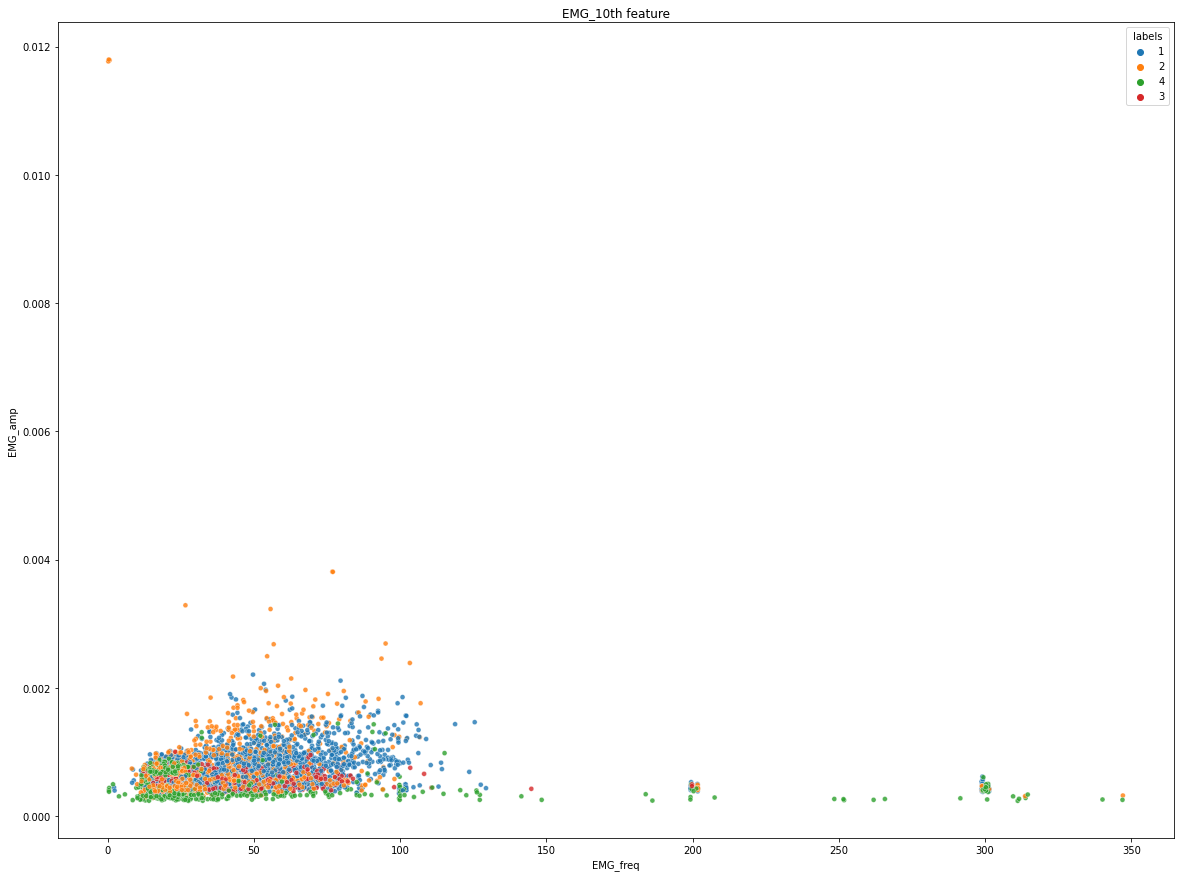

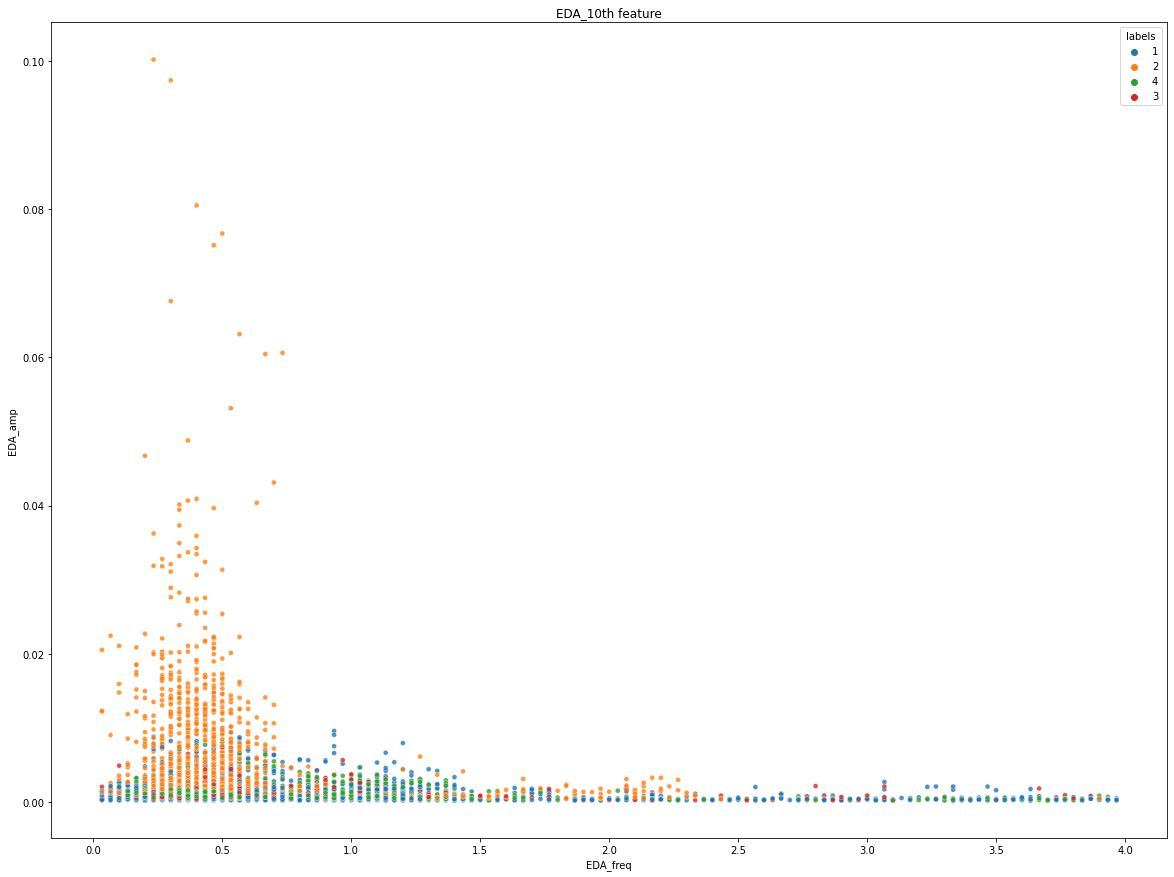

In [26]:
visualize_dataset(dataset)

In [ ]:
ecg_model_input = keras.Input(shape=(NUM_FEATURES, 2))
ecg_conv_1 = keras.layers.Conv1D(4, kernel_size=2, activation='swish')(ecg_model_input)
ecg_conv_2 = keras.layers.Conv1D(8, kernel_size=4, activation='swish')(ecg_conv_1)
ecg_flatten = keras.layers.Flatten()(ecg_conv_2)
ecg_dense_1 = keras.layers.Dense(32, activation='swish')(ecg_flatten)
ecg_dense_2 = keras.layers.Dense(16, activation='swish')(ecg_dense_1)
ecg_dense_3 = keras.layers.Dense(8, activation='swish')